In [1]:
!pip install gym
!pip install stable_baselines3
!pip install numpy
!pip install matplotlib
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 29.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827620 sha256=25bed39e9dbd79417a72a4acf6902f2cc9e674898682dc70212e344fff19bbc3
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 79.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 76.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 31.1 MB/s eta 0:00:00
  

In [2]:
!pip install imageio
!pip install procgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 45.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.1 MB/s eta 0:00:00


In [3]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import imageio


import sys
sys.path.append('../') #This is added so we can import from the source folder
from policies_impala import ImpalaCNN
from visualisation_functions import *


env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



In [4]:
@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action

def load_model(model_path = 'model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= 200:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

In [5]:
model = load_model()

save_gif_option = True  
for episode in range(1):
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")



/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (e

Episode 1 finished with total reward: 10.0


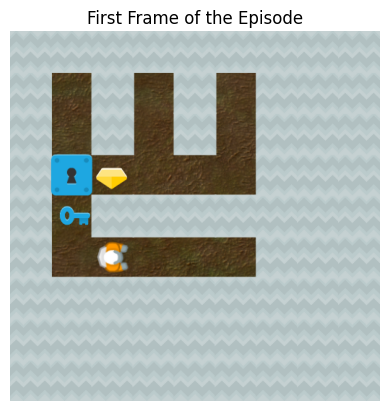

In [4]:
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")

In [8]:
import imageio

def create_gif(frames, filename, duration=0.1):
    # Write frames to GIF file
    imageio.mimsave(filename, frames, duration=duration)


create_gif(frames, "episode_gif.gif")


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def swap_colours(observation):
    blue_key_colors = [
        [27, 177, 232],
        [20, 150, 198],
        [22, 161, 212]
    ]
    green_key_colors = [
        [125, 212, 70],
        [98, 189, 34],
        [110, 195, 56]
    ]

    # Create a copy of the observation array to modify
    modified_observation = observation.copy()

    # Swap the colors of blue and green keys
    for blue_color, green_color in zip(blue_key_colors, green_key_colors):
        # Find pixels that match the blue color within a tolerance
        blue_mask = np.abs(observation - blue_color).sum(axis=-1) < 65
        modified_observation[blue_mask] = green_color

        # Find pixels that match the green color within a tolerance
        green_mask = np.abs(observation - green_color).sum(axis=-1) < 65
        modified_observation[green_mask] = blue_color
        

    return observation

    

def plot_heist_observation(observation):
    # Define the colors to swap

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the modified observation
    ax.imshow(observation)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()

In [10]:
[27, 177, 232] in observations[0]

True

In [11]:
!pip install opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 42.0 MB/s eta 0:00:0000:0100:01


In [12]:
#reading some images : blue key and gem only in opencv
import cv2
def convert_png_obs(image_png_name):
    image = cv2.imread(image_png_name)

    # Resize the image to match the original observation dimensions
    image = cv2.resize(image, (64, 64))

    # Convert the color format if necessary
    if image.shape[2] == 4:  # RGBA format
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape[2] == 1:  # Grayscale format
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Ensure the image data type matches the original observation
    image = image.astype(np.uint8)
    return image

def read_modified_image(filename):
    # Load the edited PNG image
    edited_image = cv2.imread(filename)

    # Resize the image to match the original observation dimensions
    resized_image = cv2.resize(edited_image, (64, 64))

    # Convert the color format if necessary
    if resized_image.shape[2] == 4:  # RGBA format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGBA2RGB)
    elif resized_image.shape[2] == 1:  # Grayscale format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    # Ensure the image data type matches the original observation
    resized_image = resized_image.astype(np.uint8)
    image_tensor = torch.from_numpy(resized_image)
    image_tensor =  image_tensor.unsqueeze(0)
    return image_tensor
# Use the resized_image as input to your model
# model.predict(resized_image)

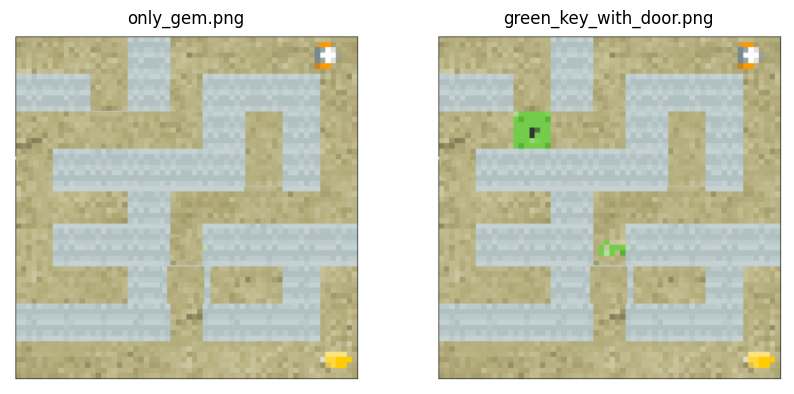

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_images_with_matplotlib(img_paths):
    fig, axes = plt.subplots(1, len(img_paths), figsize=(10, 5))
    if len(img_paths) == 1:  # Adjust if there's only one image to avoid indexing error
        axes = [axes]
    for ax, img_path in zip(axes, img_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Hide the axes
        ax.set_title(img_path.split('/')[-1])  # Set title as the image filename
    plt.show()

# Example usage
img_paths = ['only_gem.png', 'green_key_with_door.png']
visualize_images_with_matplotlib(img_paths)

In [15]:
only_gem_input = convert_png_obs('only_gem.png')
only_blue_key_input = convert_png_obs('blue_key_no_door.png')
tensor_gem = read_modified_image('only_gem.png')
tensor_blue_key = read_modified_image('blue_key_no_door.png')
tensor_green_key_door = read_modified_image('green_key_with_door.png')


In [16]:
import torch
import torch.distributions

class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks


    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations
        for path in layer_paths:
            self.register_hook_by_path(path, path.replace('.', '_'))
        output = self.model(input)
        return output, self.activations



In [17]:
model_activations = ModelActivations(model)
layer_paths1 = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]
output1, activations1 = model_activations.run_with_cache(tensor_gem, layer_paths1)
model_activations.clear_hooks()
output2, activations2 = model_activations.run_with_cache(tensor_blue_key, layer_paths1)
tensor_green_key_door 
output2, activations3 = model_activations.run_with_cache(tensor_green_key_door, layer_paths1)


In [18]:
differences = {}
for key in activations1:
    # Compute the difference tensor for the current key
    difference = activations3[key][0] - activations1[key][0]
    
    # Store the difference tensor in a new dictionary
    differences[key] = difference
    print(difference.shape)

    # Check if there are any non-zero differences
    has_non_zero = torch.any(difference != 0)
    
    if has_non_zero:
        print(f"Key: {key} has non-zero differences.")
    else:
        print(f"Key: {key} has only zero differences.")
print(differences)

torch.Size([16, 64, 64])
Key: conv_seqs_0_conv has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv1 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv1 has non-zero differences.
torch.Size([32, 32, 32])
Key: conv_seqs_1_conv has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_2_conv has non-zero differences.
torch.Size([32, 8, 8])
Key: conv_seqs_2_res_block0_conv0 has non-zero differences.
torch.Size([32, 8,

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])


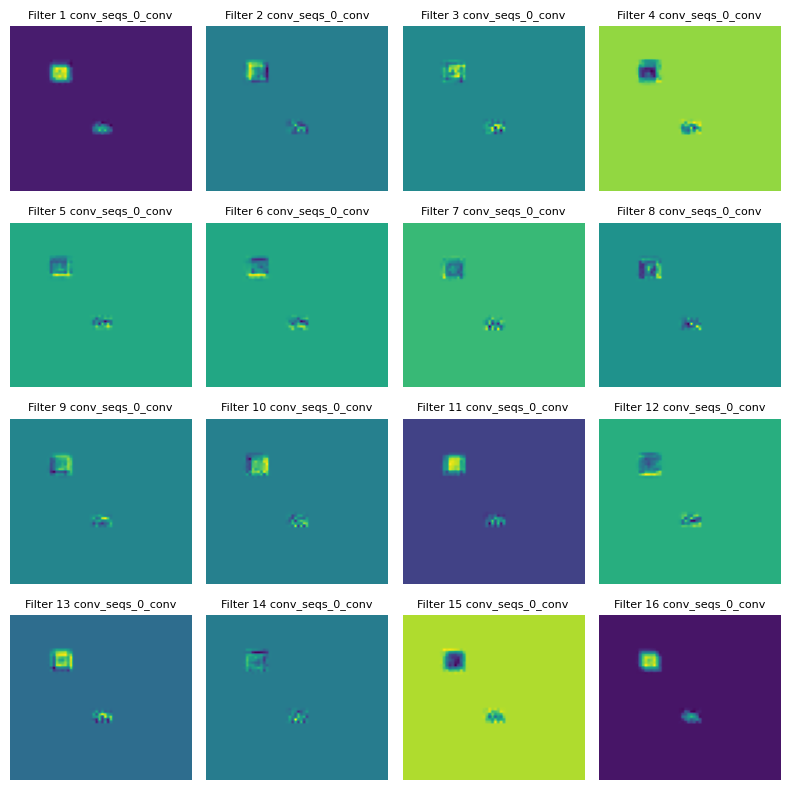

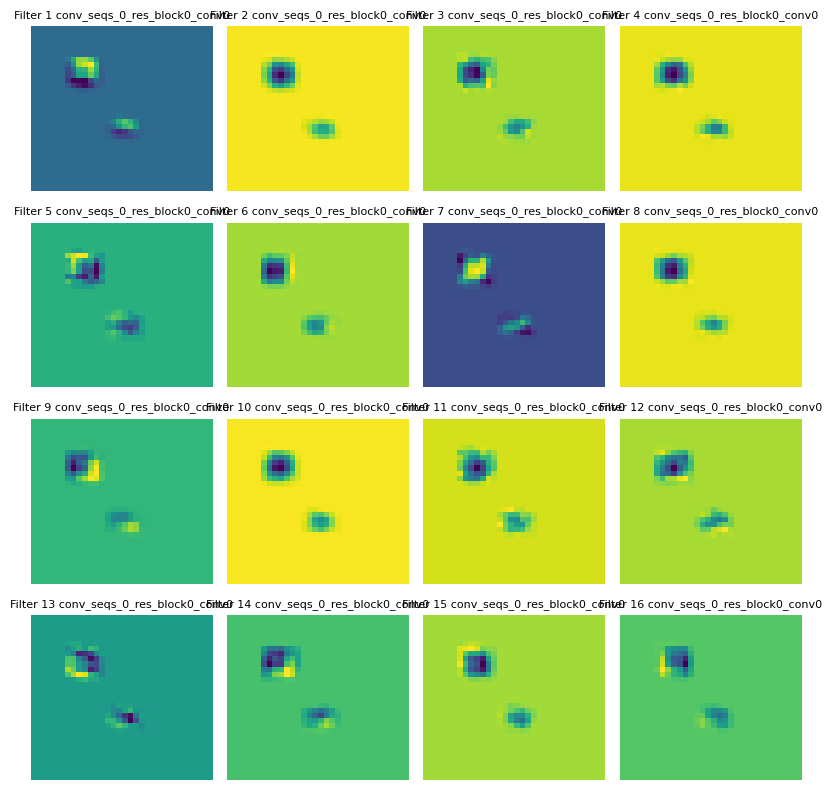

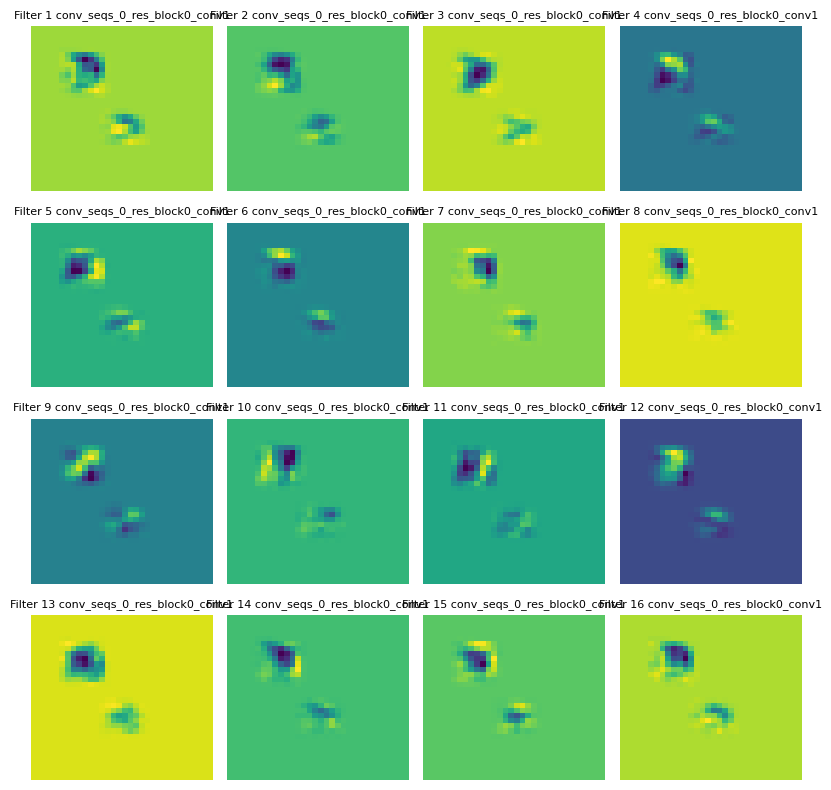

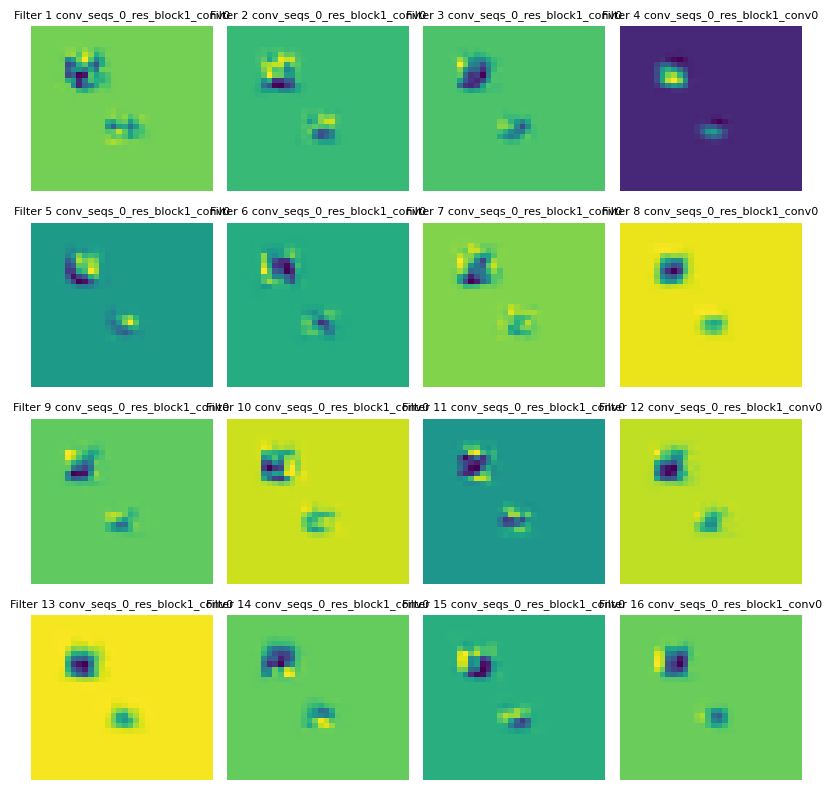

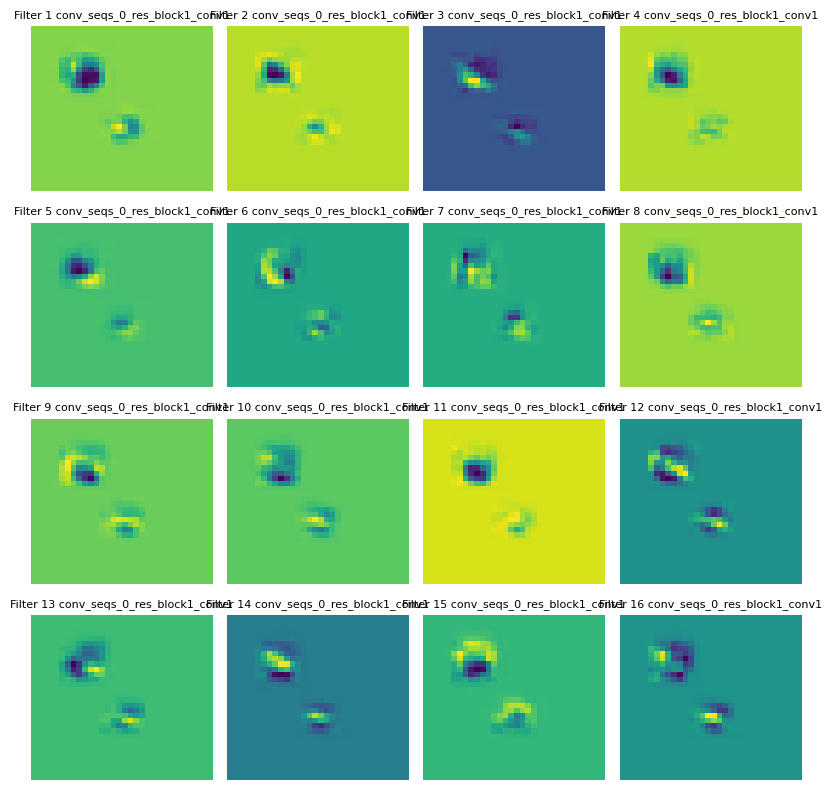

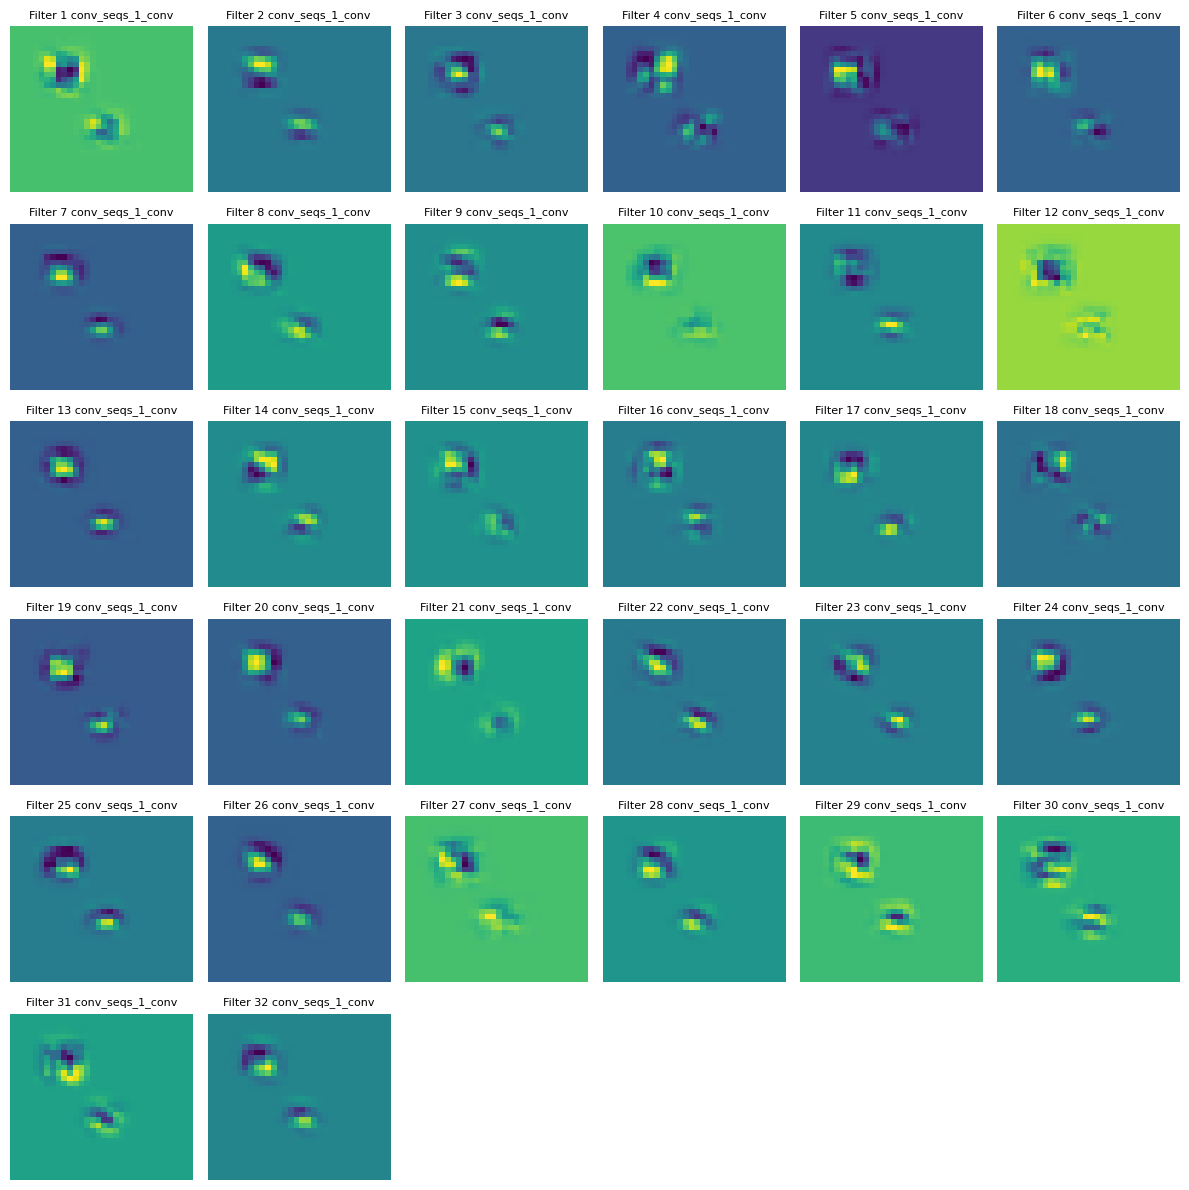

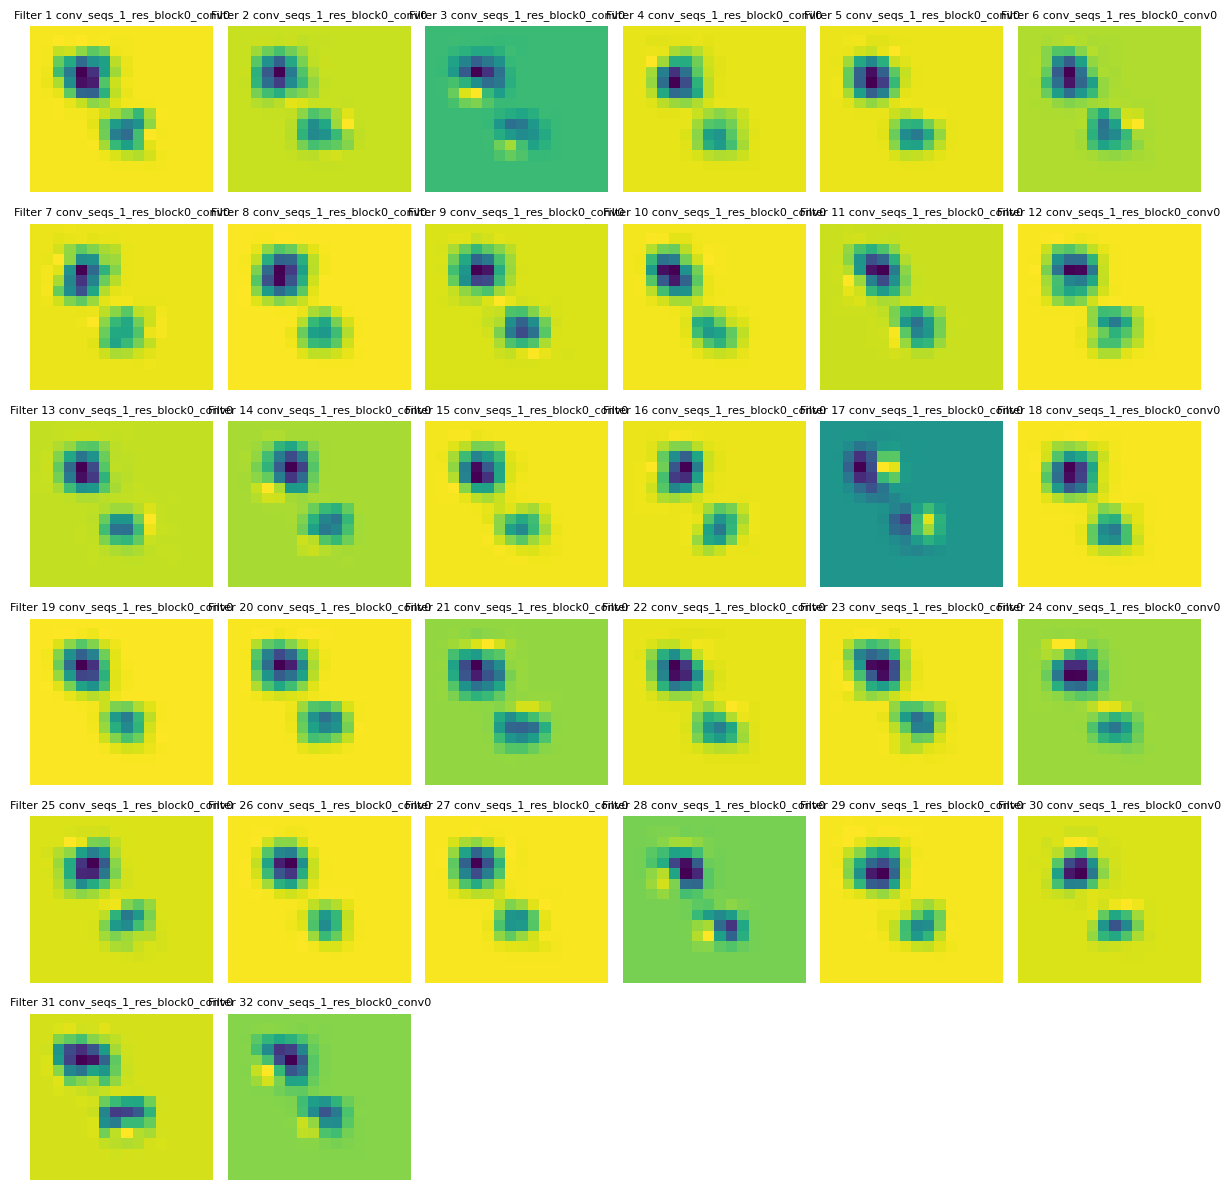

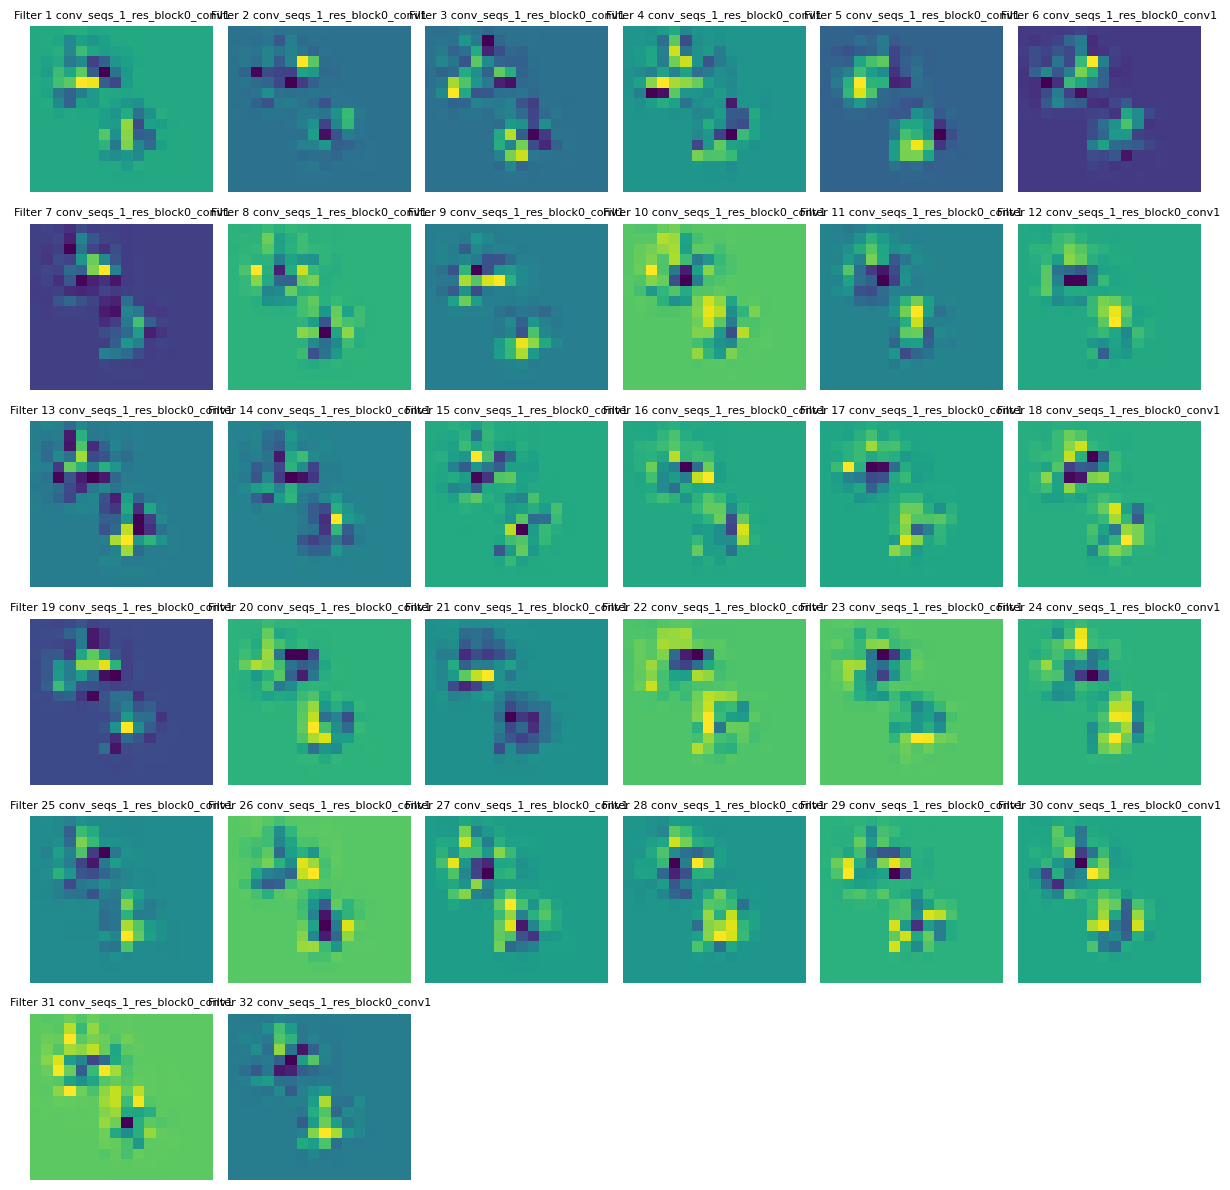

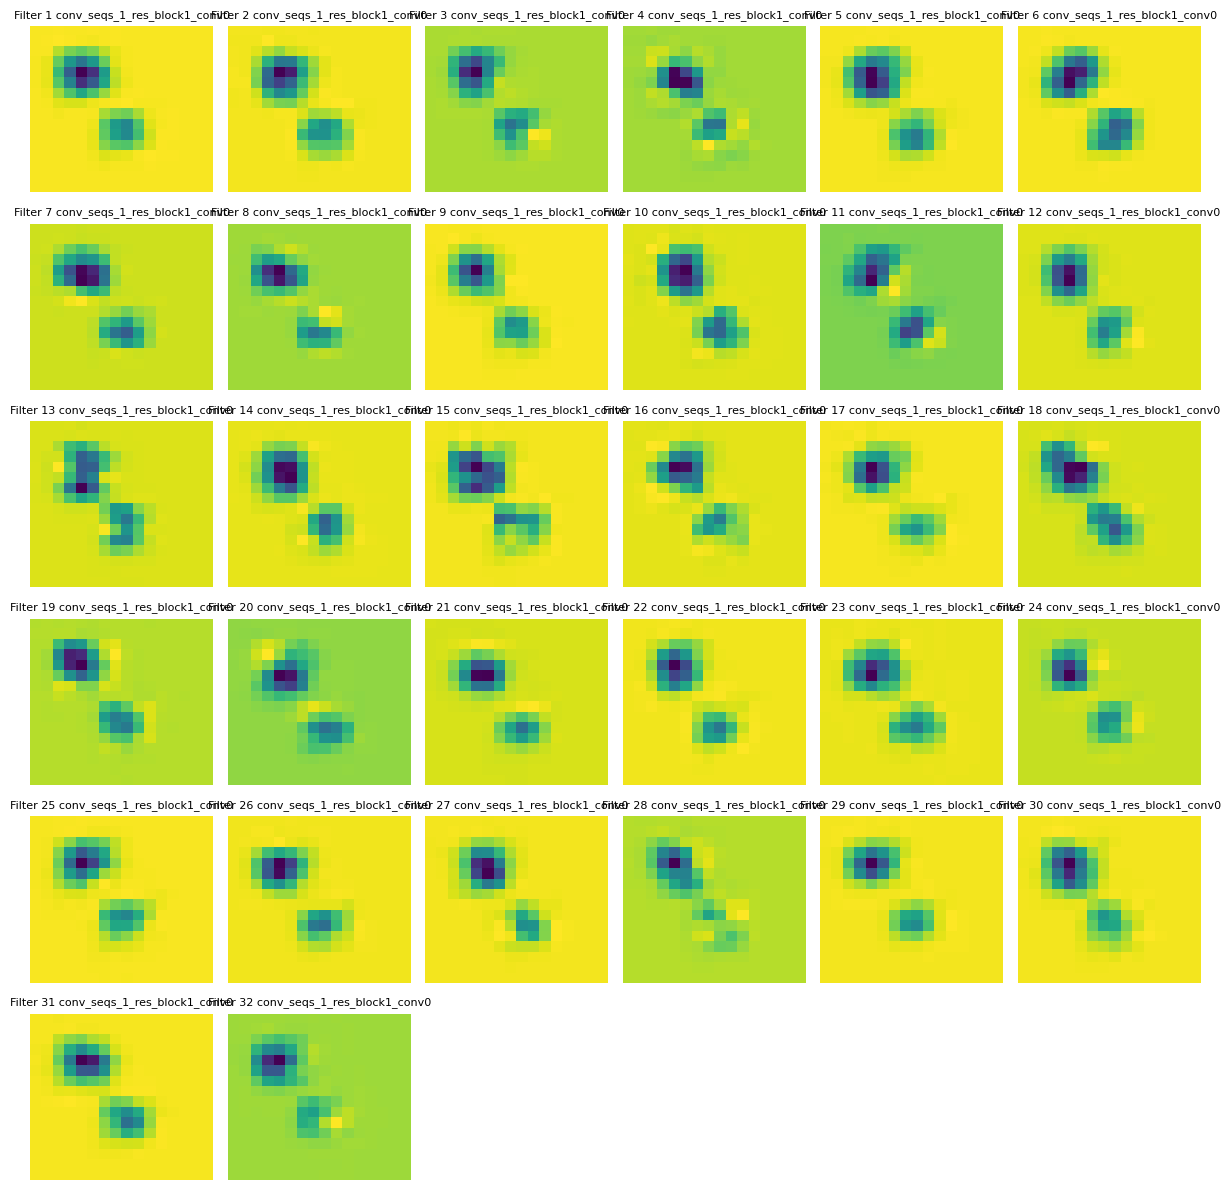

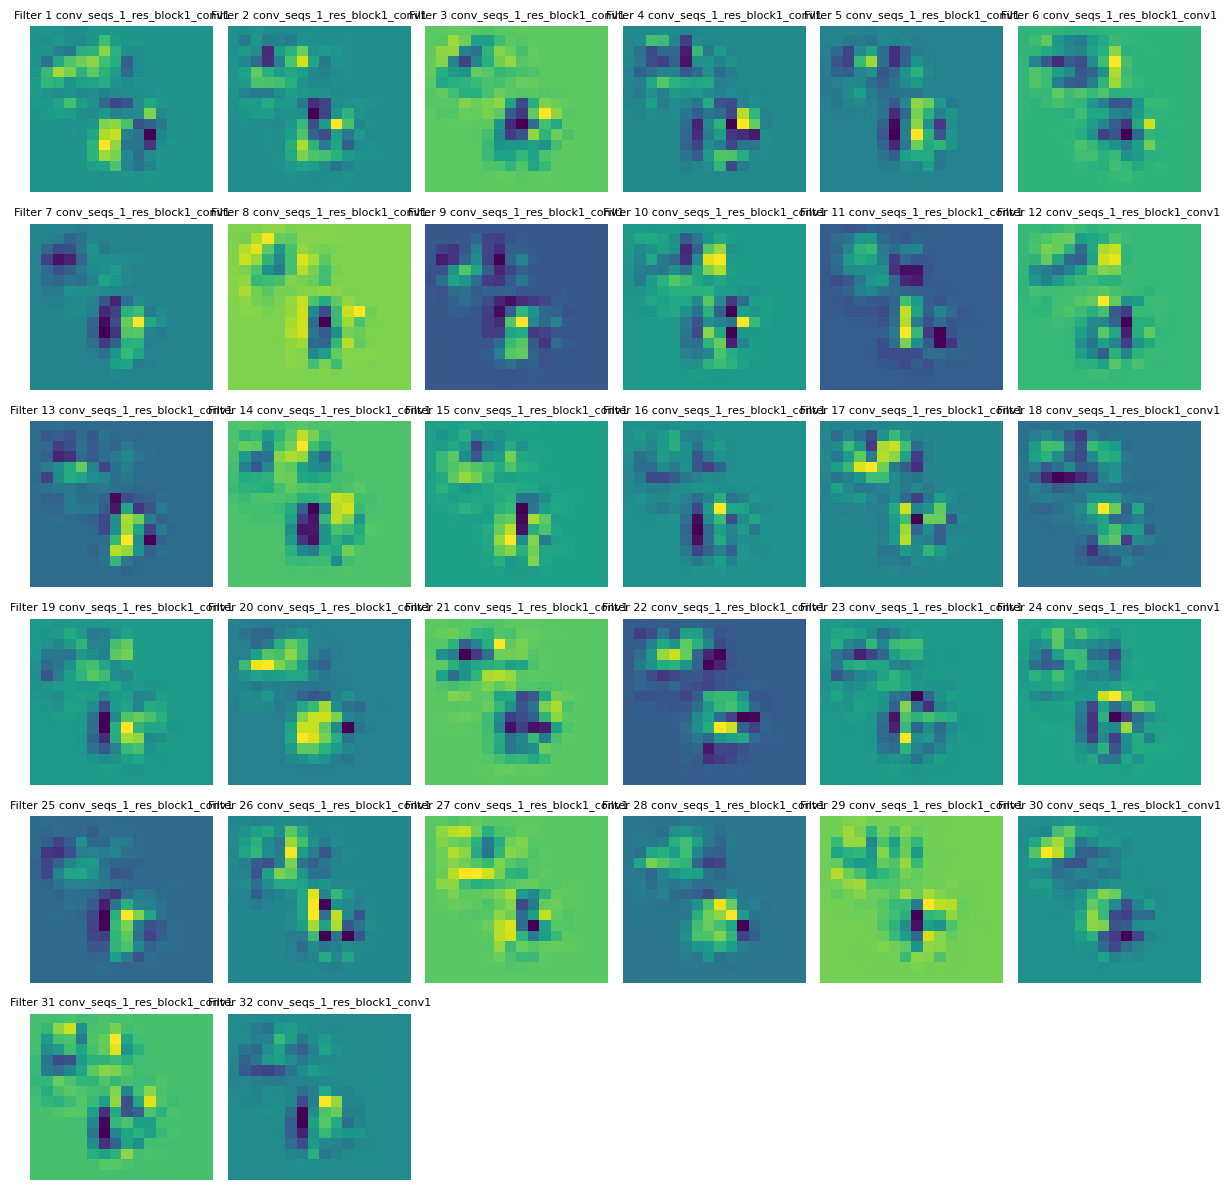

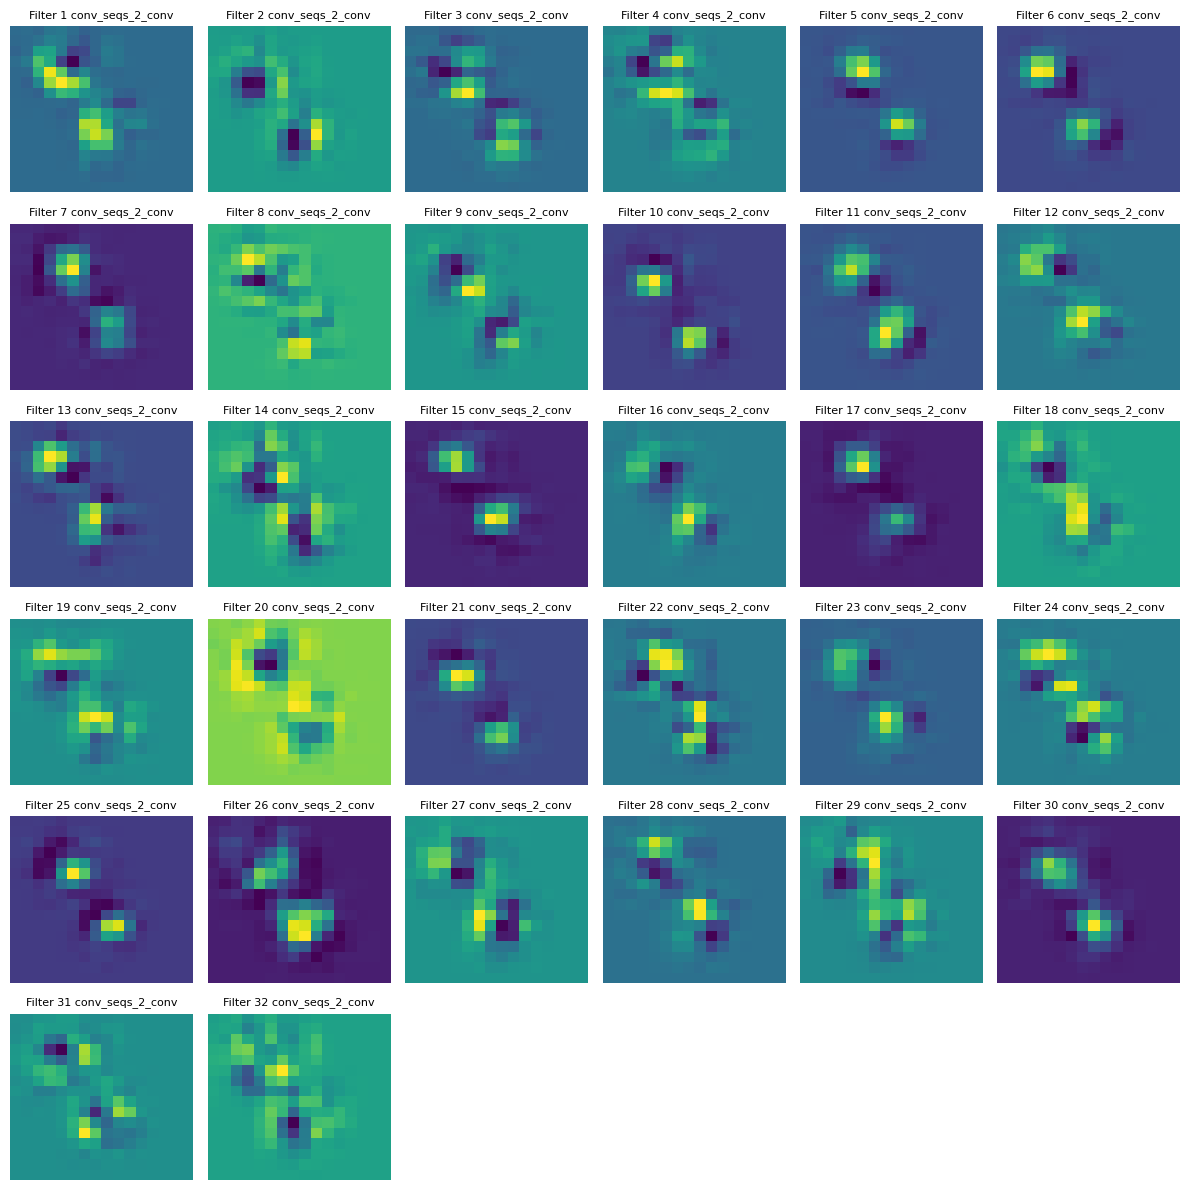

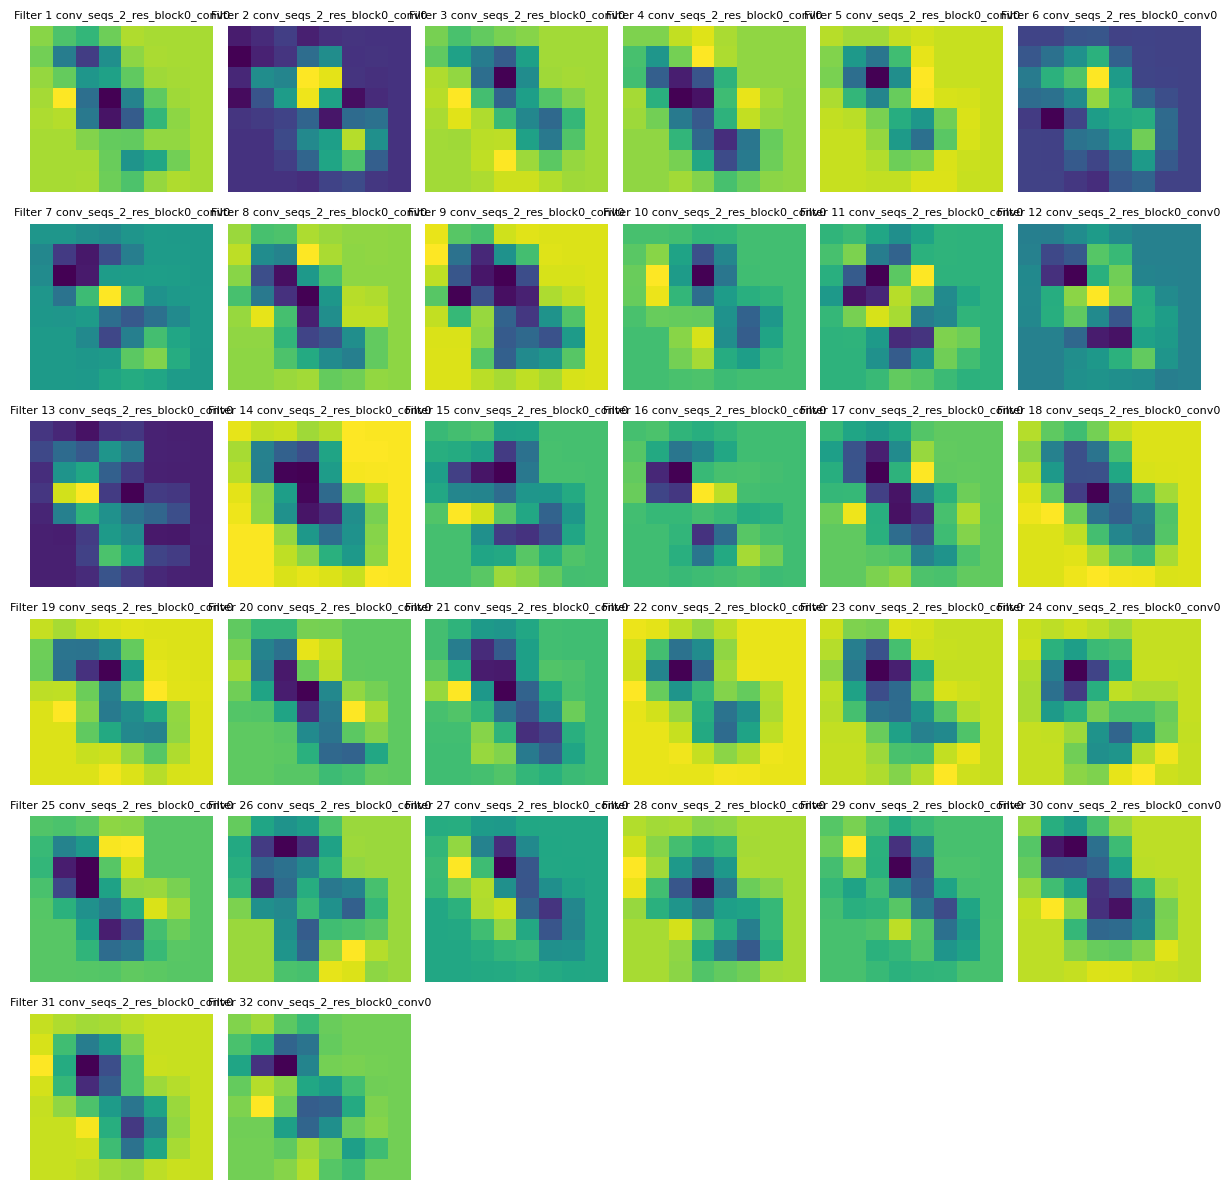

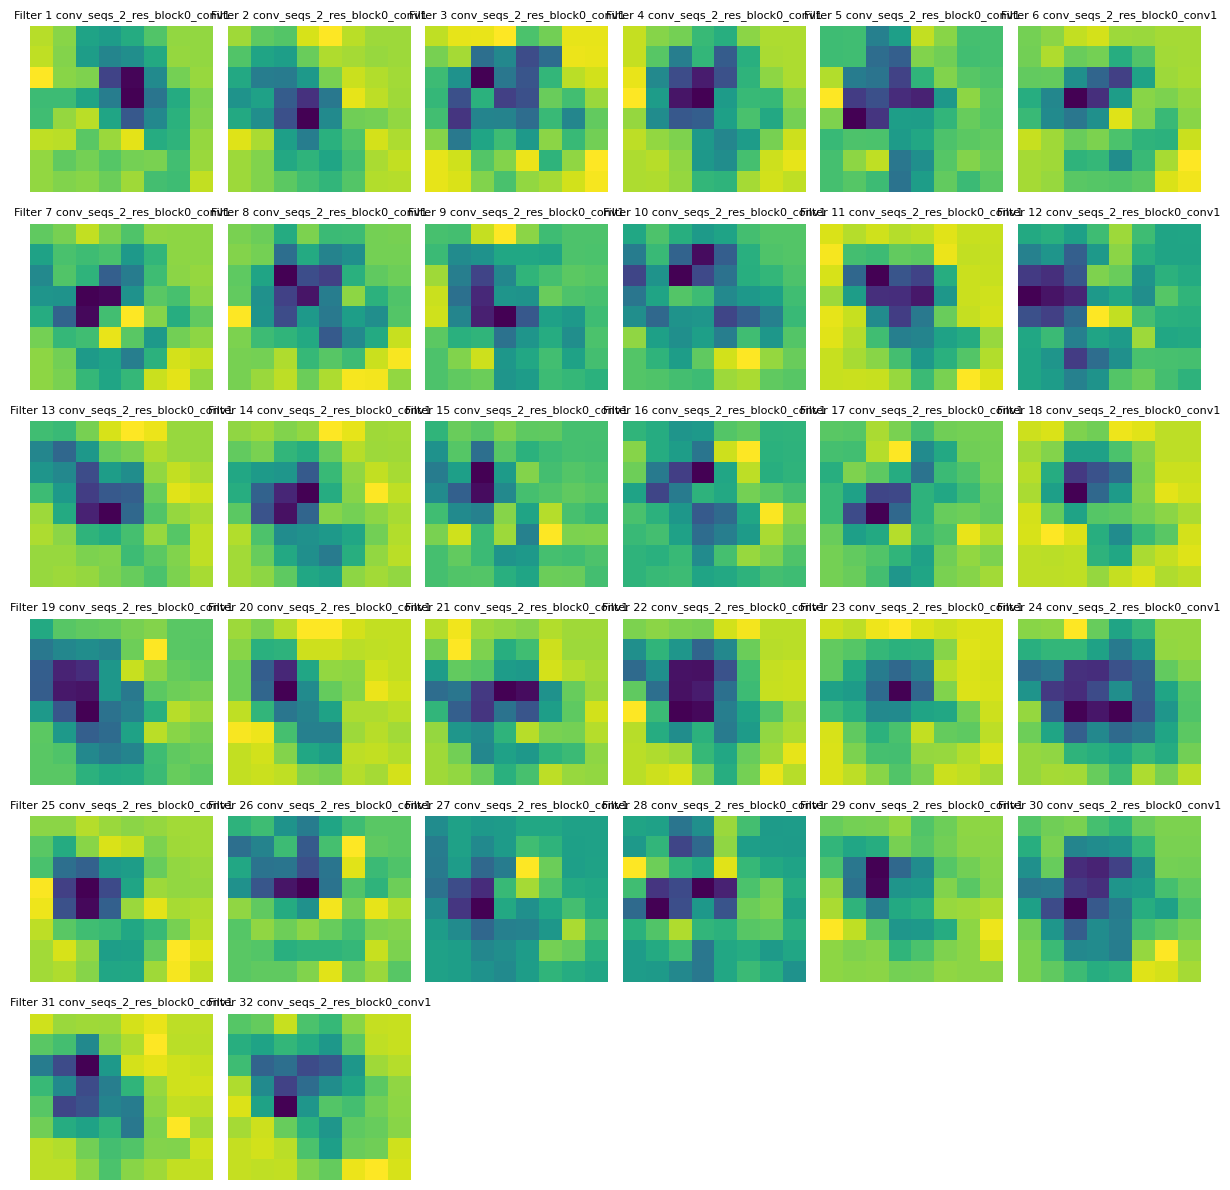

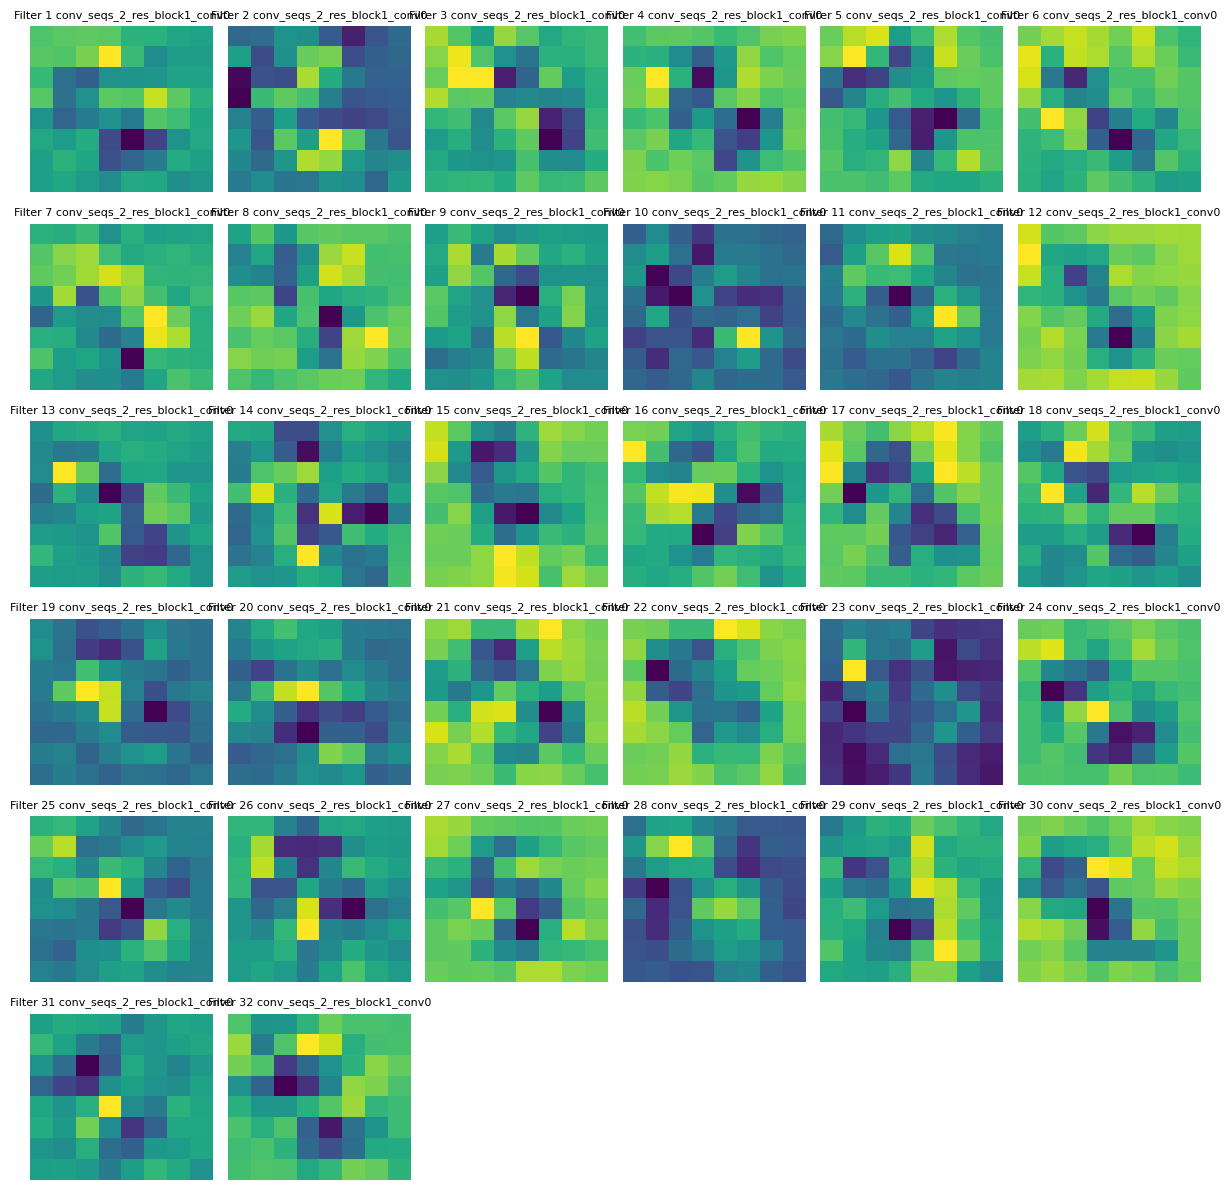

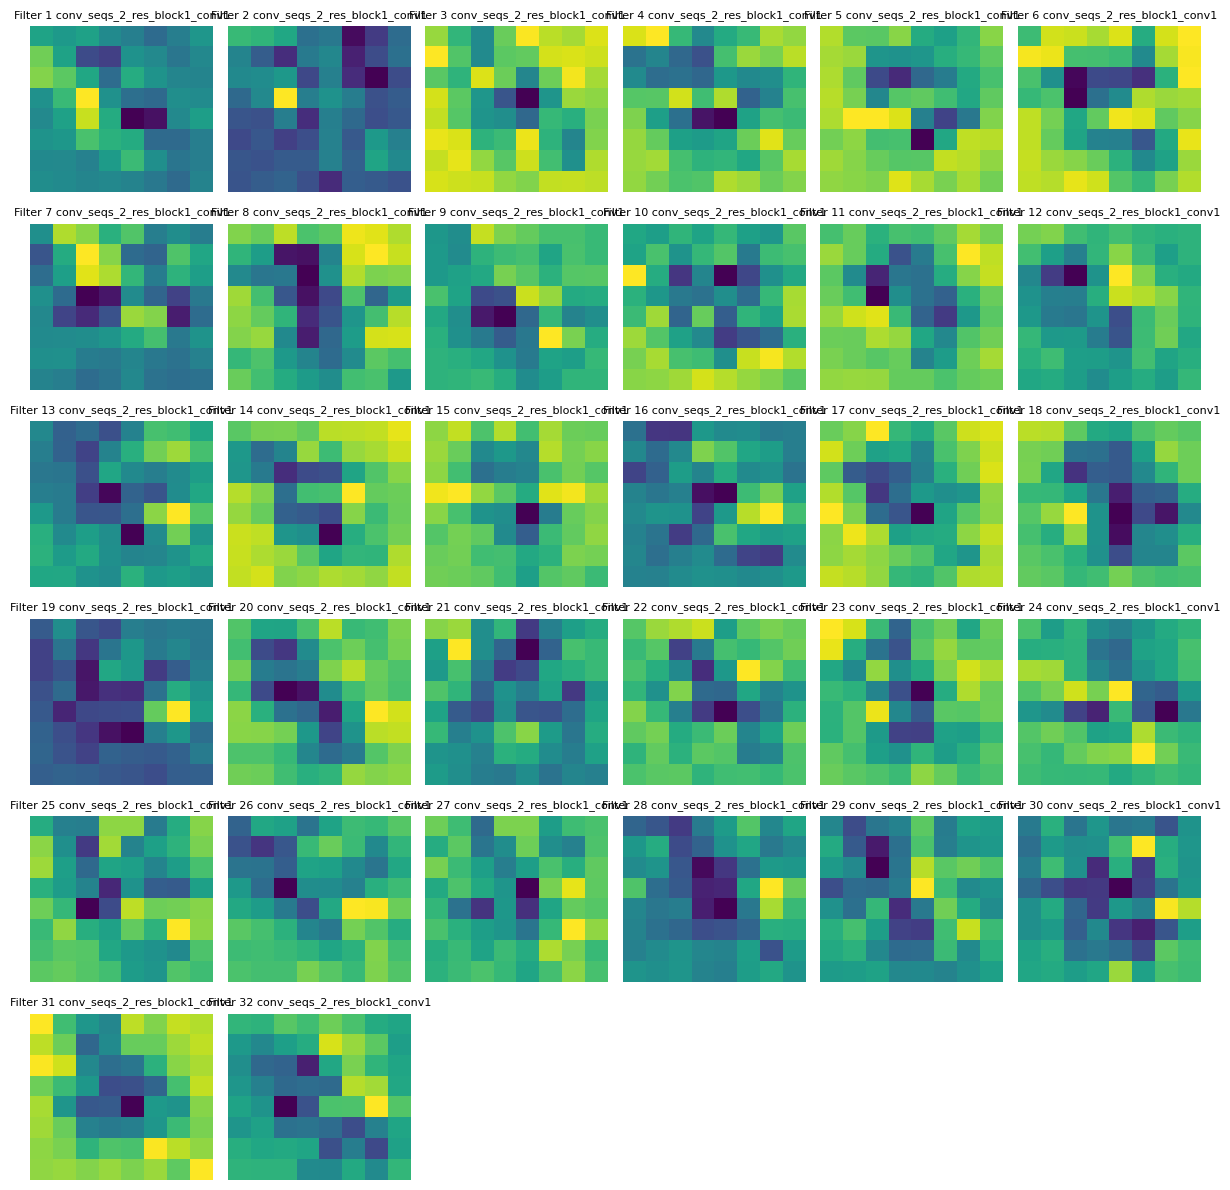

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_activations_for_layers(activations, layer_paths, save_filename_prefix=None):
    for layer_name in layer_paths:
        # Check if the specified layer's activations are available
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue

        # Extract the activation tensor for the specified layer
        #activation_tensor = activations[layer_name].cpu().numpy()
        activation_tensor = activations[layer_name]
        # The tensor is 3-dimensional [channels, height, width]
        num_activations = activation_tensor.shape[0]  # Number of activation maps
        
        # Calculate grid size
        grid_size = math.ceil(math.sqrt(num_activations))
        
        # Create a figure with dynamic subplots based on the number of activations
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        if grid_size == 1:
            axes = np.array([[axes]])  # Ensure axes can be indexed with two dimensions

        # Initialize an index for activation maps
        activation_idx = 0

        for i in range(grid_size):
            for j in range(grid_size):
                ax = axes[i, j]
                
                # Plot the activation map if we haven't gone through all of them yet
                if activation_idx < num_activations:
                    ax.imshow(activation_tensor[activation_idx, :, :], cmap='viridis', aspect='auto')
                    ax.set_title(f'Filter {activation_idx+1} {layer_name}', fontsize=8)
                    activation_idx += 1
                else:
                    ax.axis('off')  # Hide axes without data
                
                ax.axis('off')  # Hide axes for all plots for a cleaner look

        plt.tight_layout()
        
        # Save or show the plot
        if save_filename_prefix:
            save_filename = f"{save_filename_prefix}_{layer_name}.png"
            plt.savefig(save_filename)
            plt.close()
        else:
            plt.show()


layer_paths = differences.keys()
print(layer_paths)
plot_activations_for_layers(differences, layer_paths)


In [25]:
def compute_difference(activations1, activations2):
    differences = {}
    non_zero_difference_keys = []

    # Ensure both dictionaries have the same number of entries
    if len(activations1) != len(activations2):
        raise ValueError("Dictionaries do not have the same number of elements")
    
    for (key1, value1), (key2, value2) in zip(activations1.items(), activations2.items()):
        # Compute the difference tensor for the current keys
        difference = value2[0] - value1[0]
        
        # Store the difference tensor in a new dictionary using key1 for reference
        differences[key1] = difference

        # Check if there are any non-zero differences
        has_non_zero = torch.any(difference != 0)
        
        if has_non_zero:
            non_zero_difference_keys.append((key1, key2))

    
    return differences, non_zero_difference_keys

In [16]:
layer_paths1 = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]
output, cache_gem = model_activations.run_with_cache(tensor_gem, layer_paths1)

In [117]:
#if to_patch_activation is not of the right shape, we just ablate at that given layer
def patch_activations(input,layer_names, to_patch_activation_tensor = 0,to_change_name='conv_seqs.0.conv',ablate ="True"):
    cached_activations = {}
    
    # Define a factory function to create hook functions with a stable layer name
    def make_hook(layer_name):
        def saves_cache(module, input, output):
            cached_activations[layer_name] = output.detach()
            if ablate:
                    return output* 0
            elif layer_name == to_change_name:
                print("Here are the shapes",to_patch_activation_tensor.shape, output.shape)
                if to_patch_activation_tensor.shape == output.shape:                
                    return  to_patch_activation_tensor
                
        return saves_cache
    
    # Function to recursively get a sub-module from its name
    def get_submodule(module, submodule_name):
        names = submodule_name.split('.')
        for name in names:
            module = getattr(module, name)
        return module
    
    # Register the hooks
    hooks = []
    for name in layer_names:
        layer = get_submodule(model, name)
        hook = make_hook(name)  # Create a hook with a stable layer name
        hooks.append(layer.register_forward_hook(hook))

    output = model(input)  # Assuming tensor_gem is defined elsewhere
    for hook in hooks:
        hook.remove()

    return output, cached_activations


In [118]:
#Here is how to use the patch_activations for both patching and ablation

output, cache_gem = model_activations.run_with_cache(tensor_gem, layer_paths1)
output, cache_blue_key = model_activations.run_with_cache(tensor_blue_key, layer_paths1)
to_patch_activations = cache_blue_key['conv_seqs_0_conv'][0]
to_patch_activations = to_patch_activations.unsqueeze(0)

patched_output, patched_activations= patch_activations(tensor_gem,layer_paths1,to_patch_activations,'conv_seqs.0.conv',False)
ablated_output, ablated_activations= patch_activations(tensor_gem,layer_paths1,'conv_seqs.0.conv',True)

Here are the shapes torch.Size([1, 16, 64, 64]) torch.Size([1, 16, 64, 64])


In [119]:
difference_patched_activations, non_zero_key_differences = compute_difference(cache_gem,patched_activations)
difference_ablated_activations, non_zero_key_differences = compute_difference(cache_gem,ablated_activations)

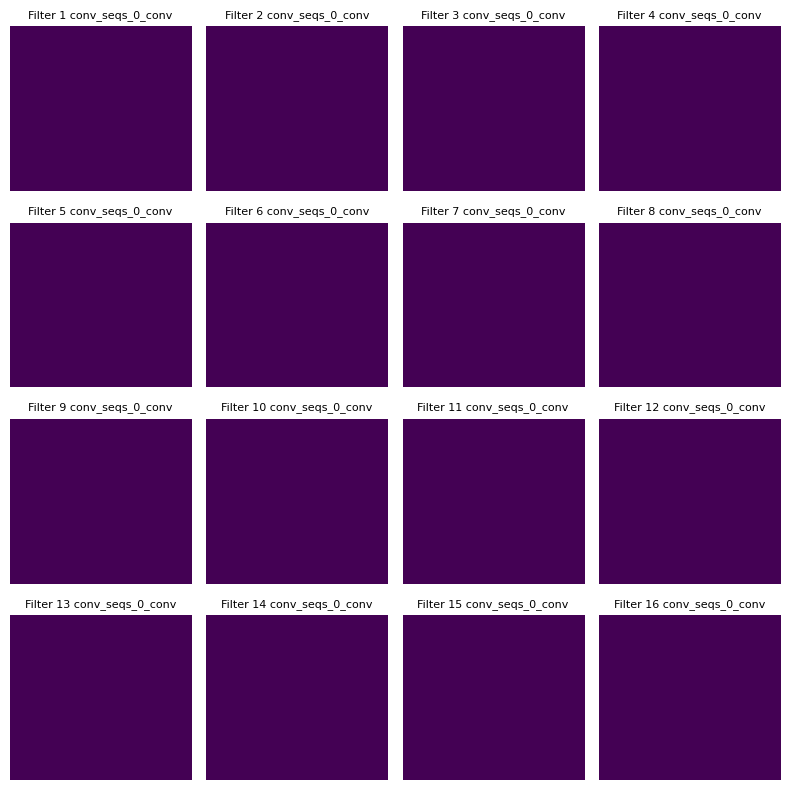

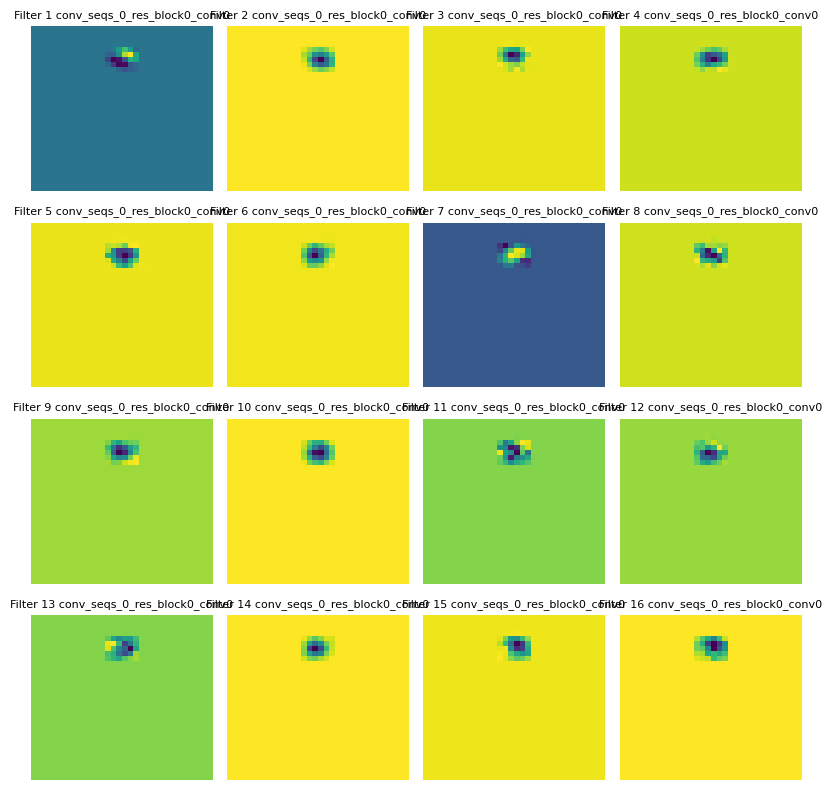

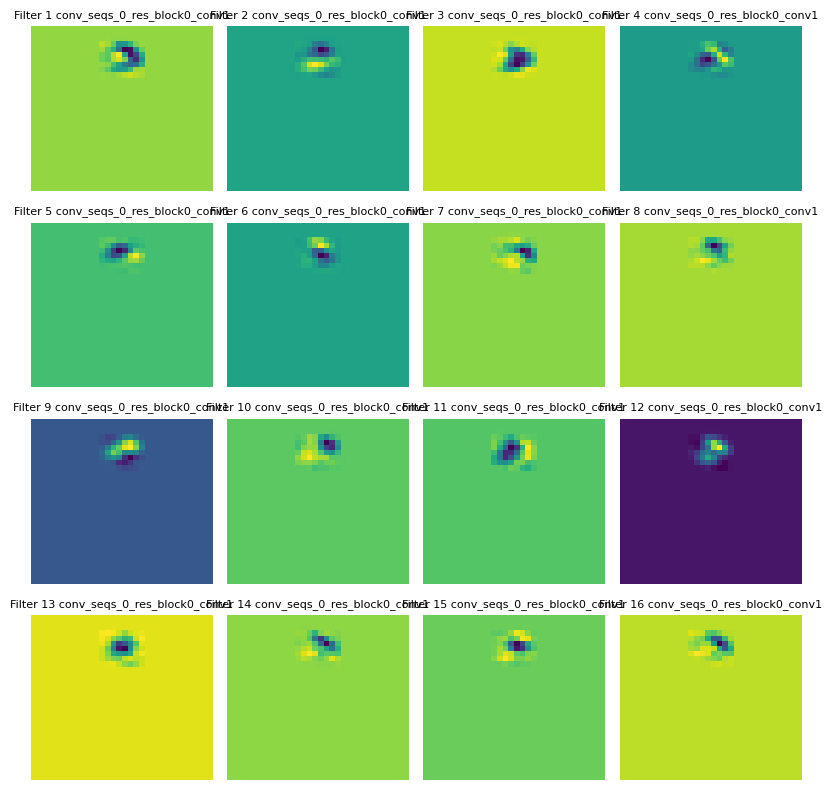

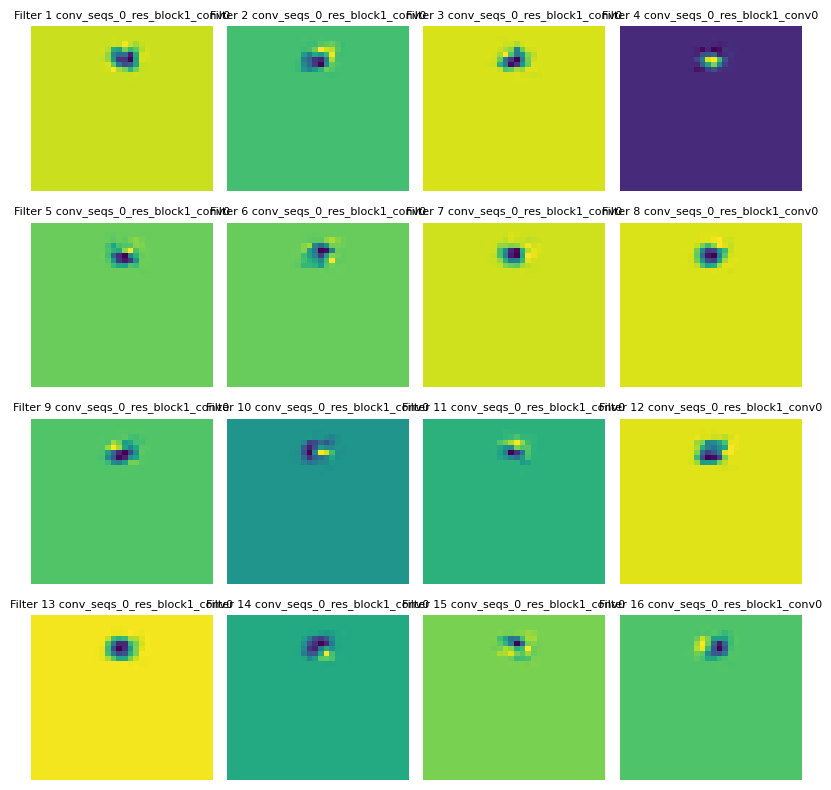

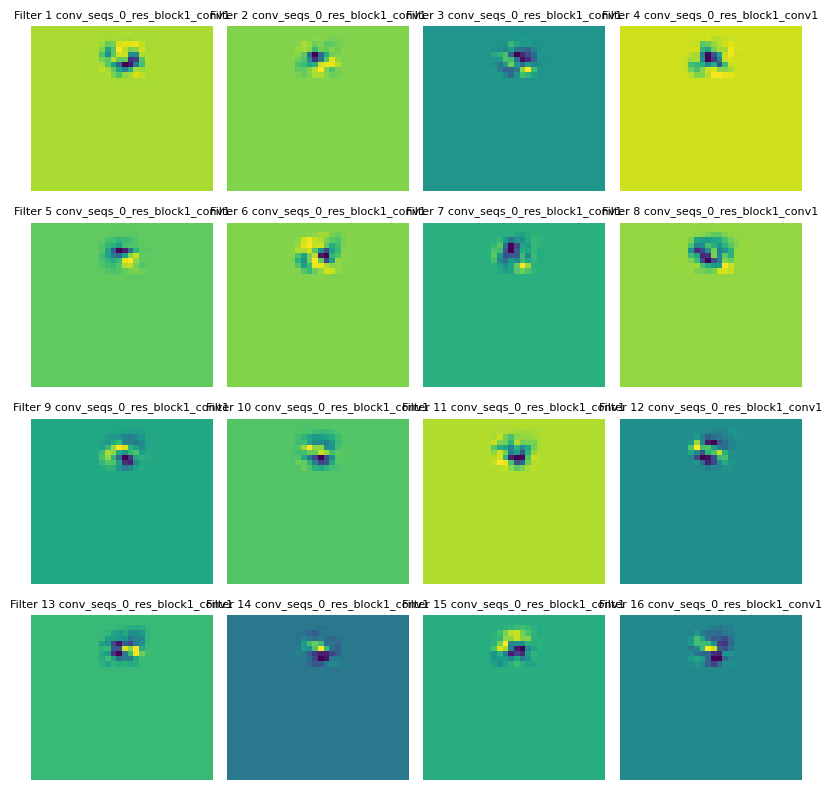

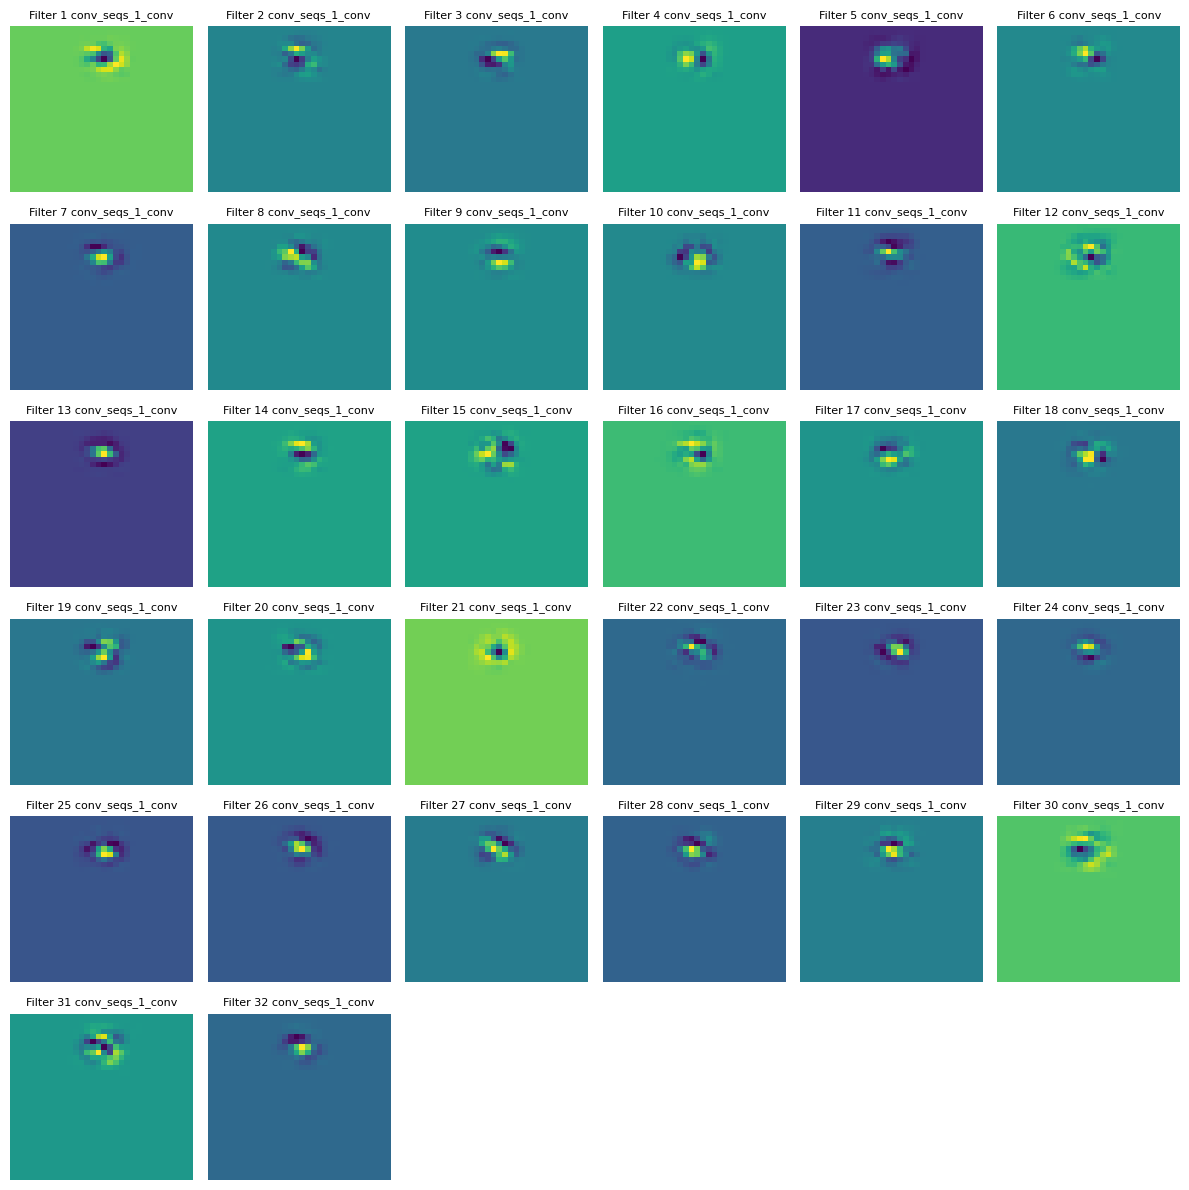

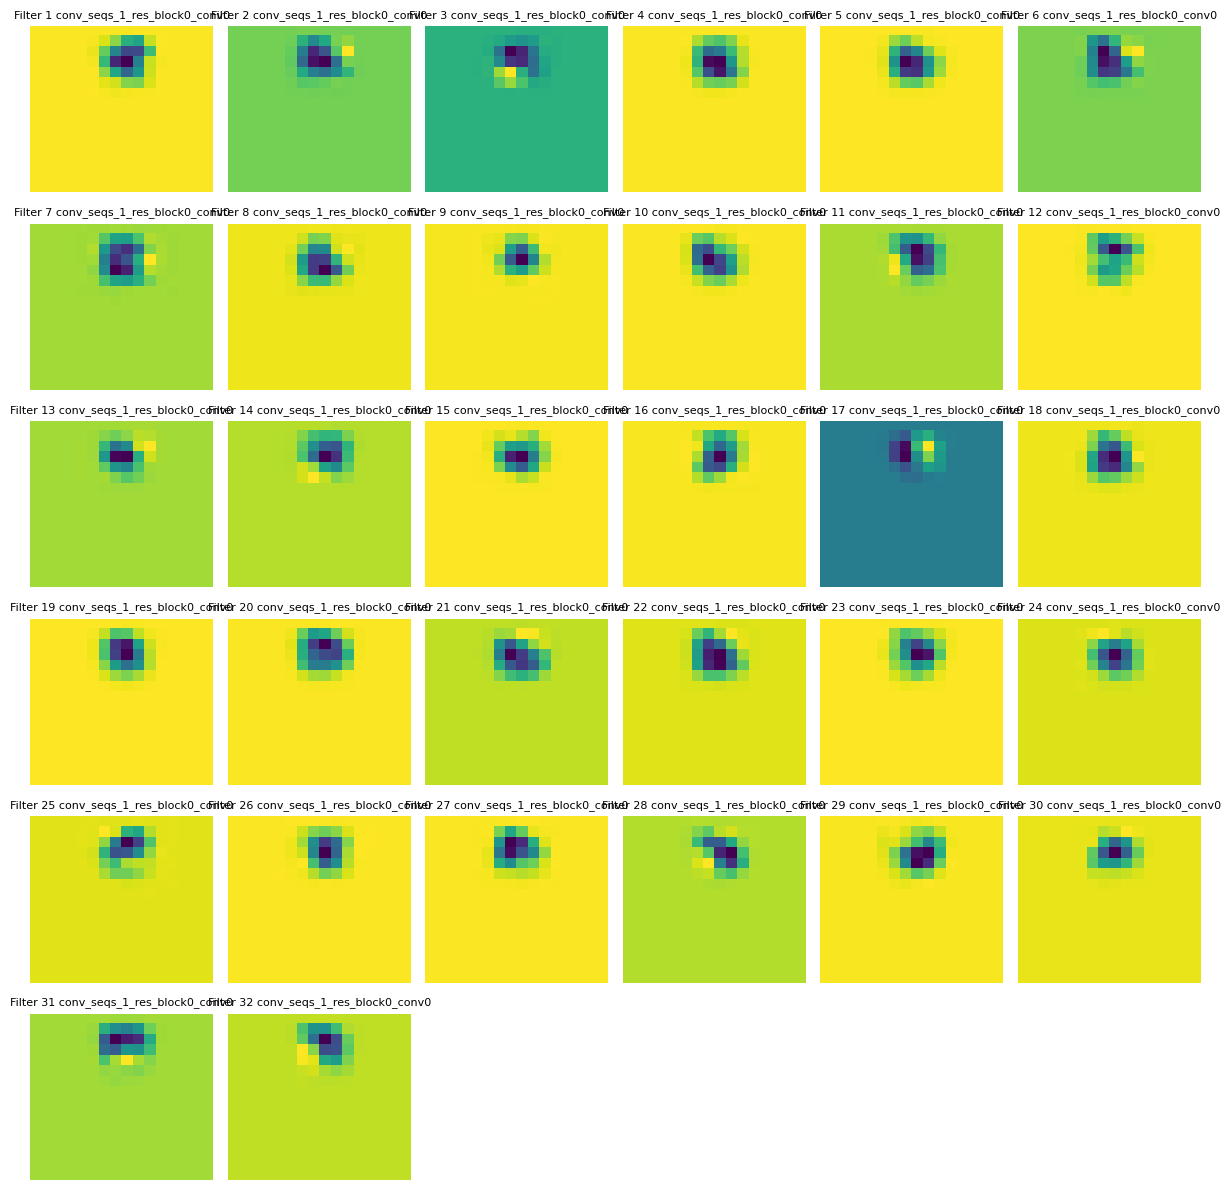

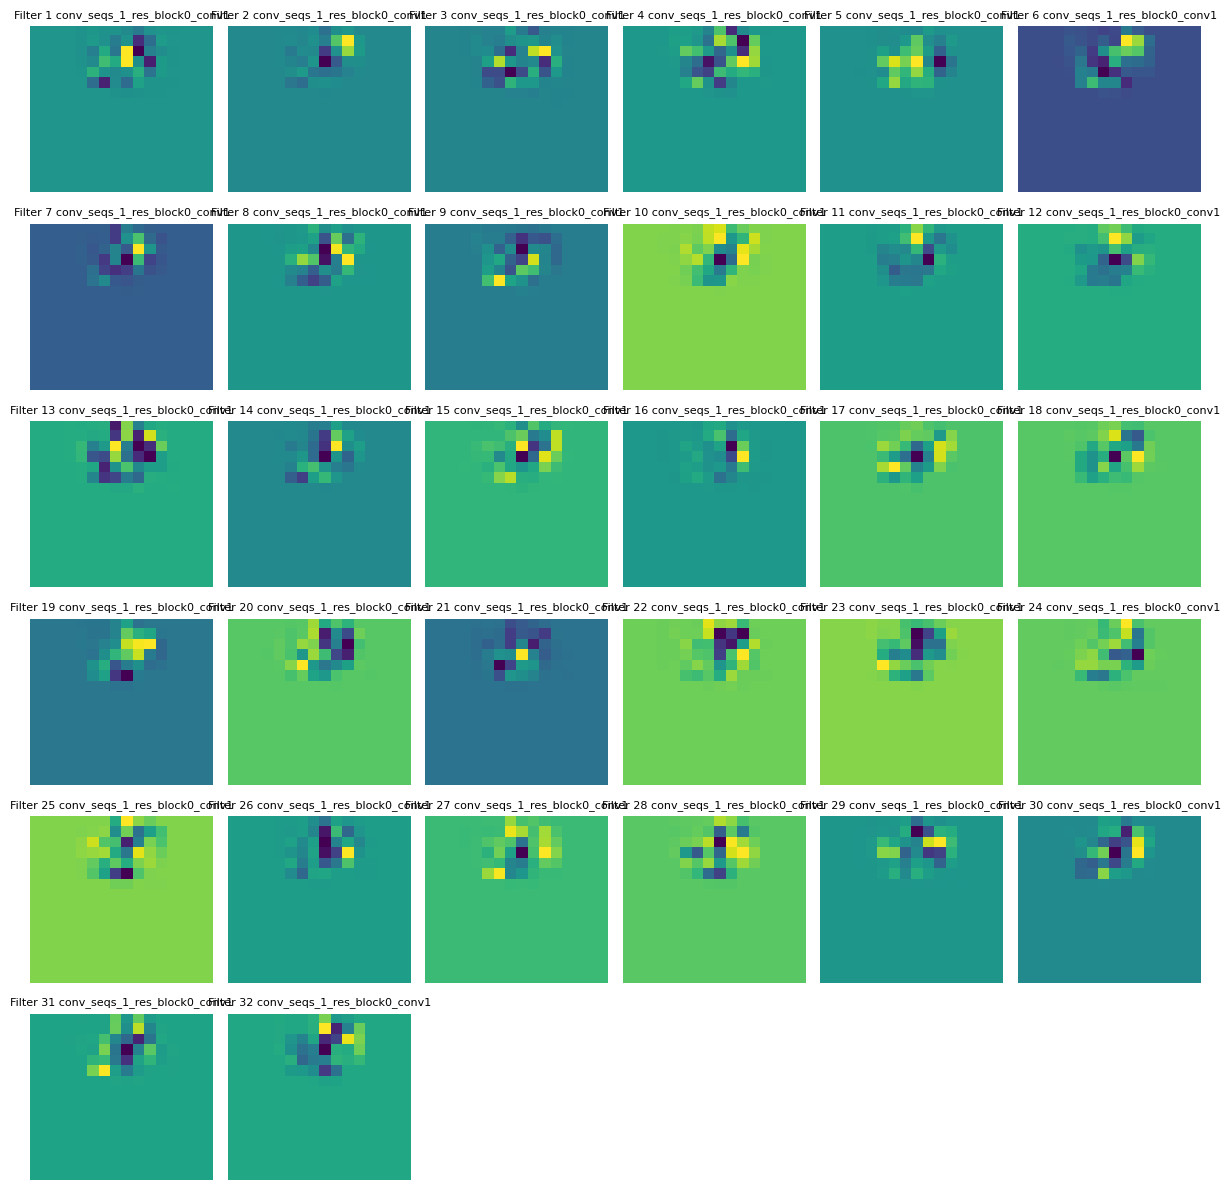

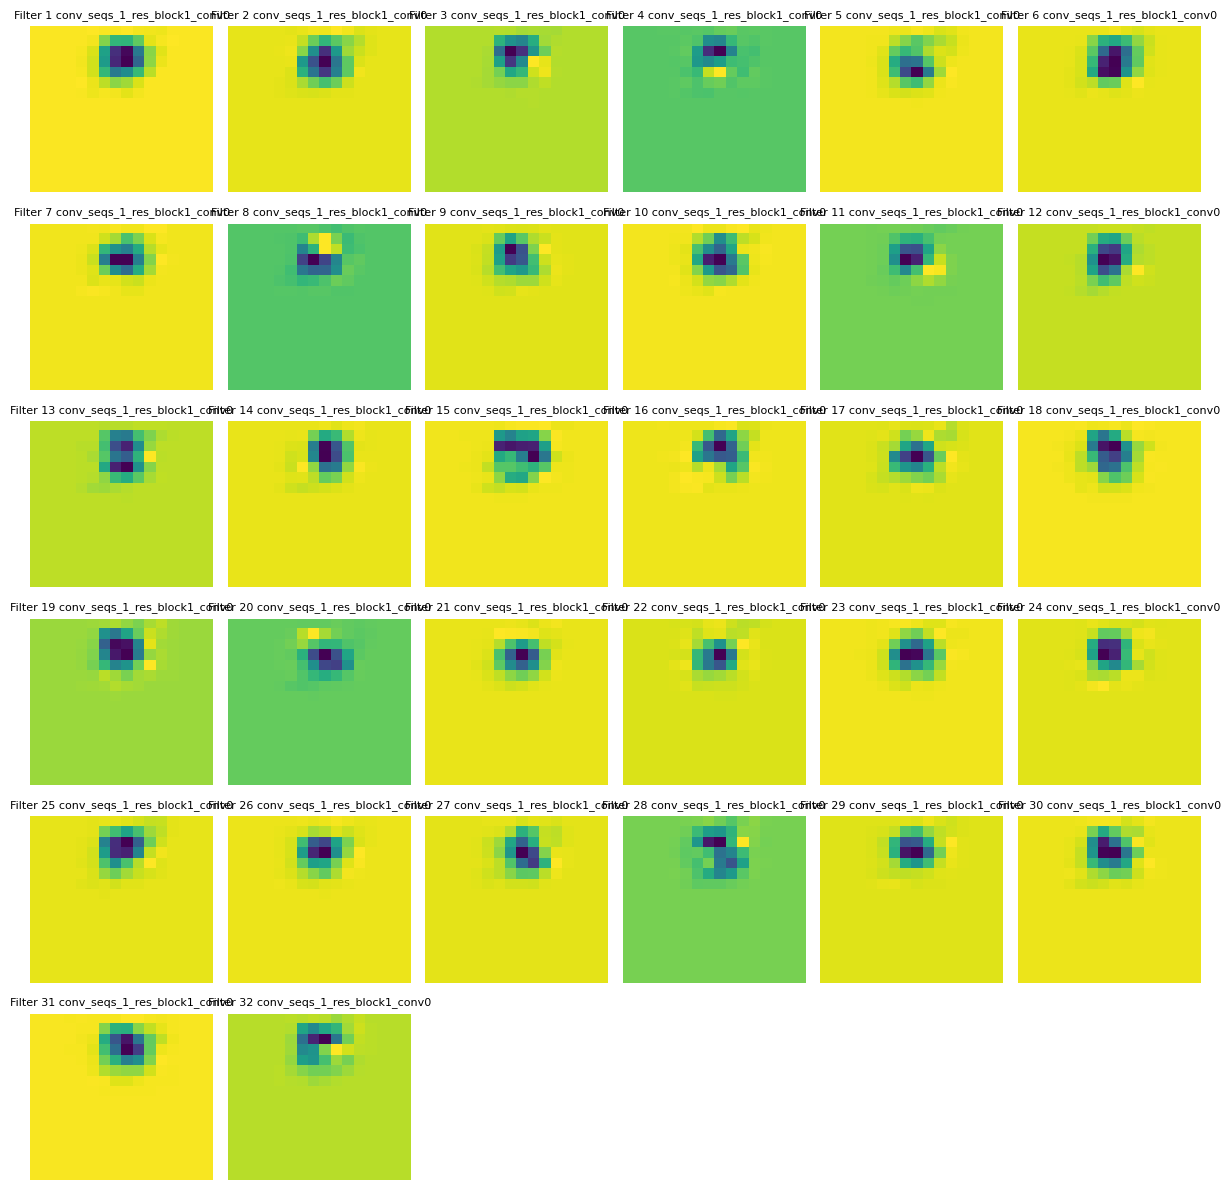

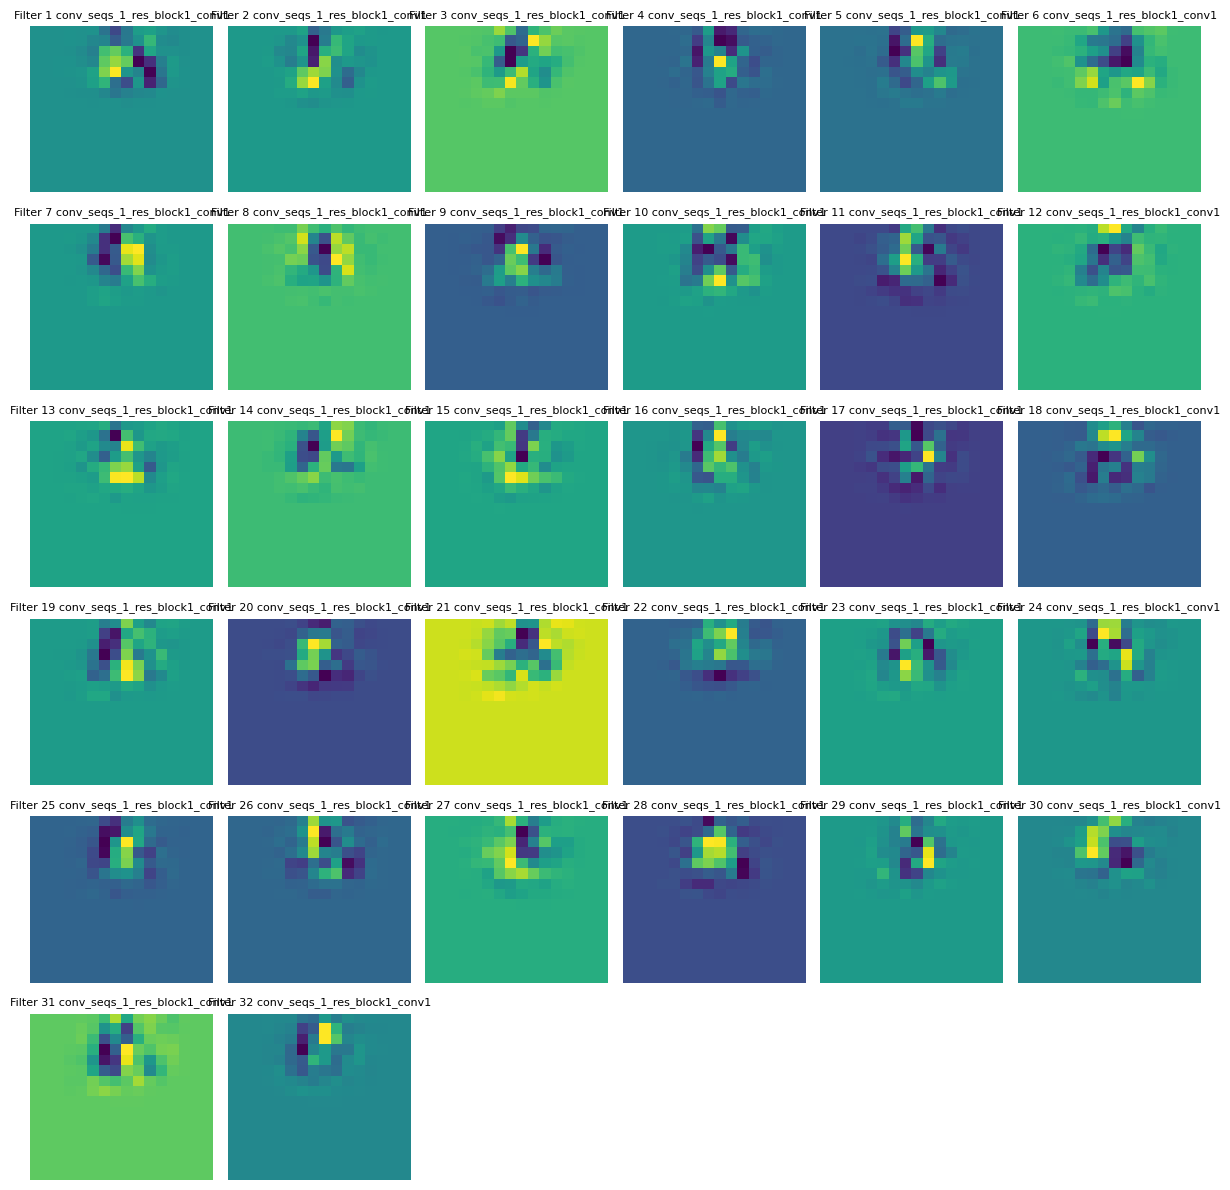

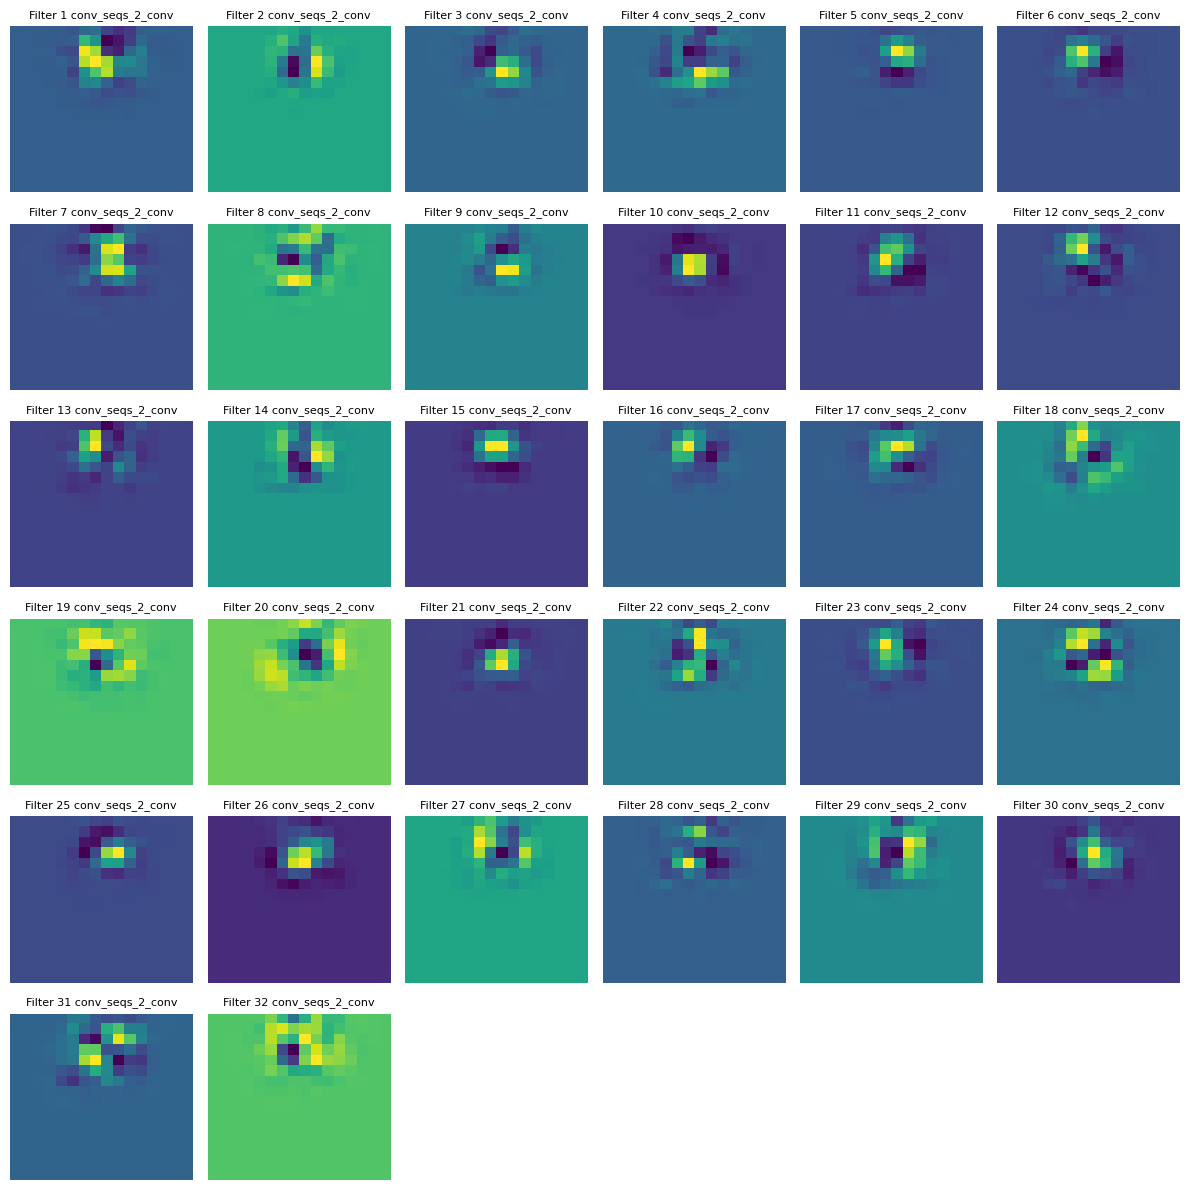

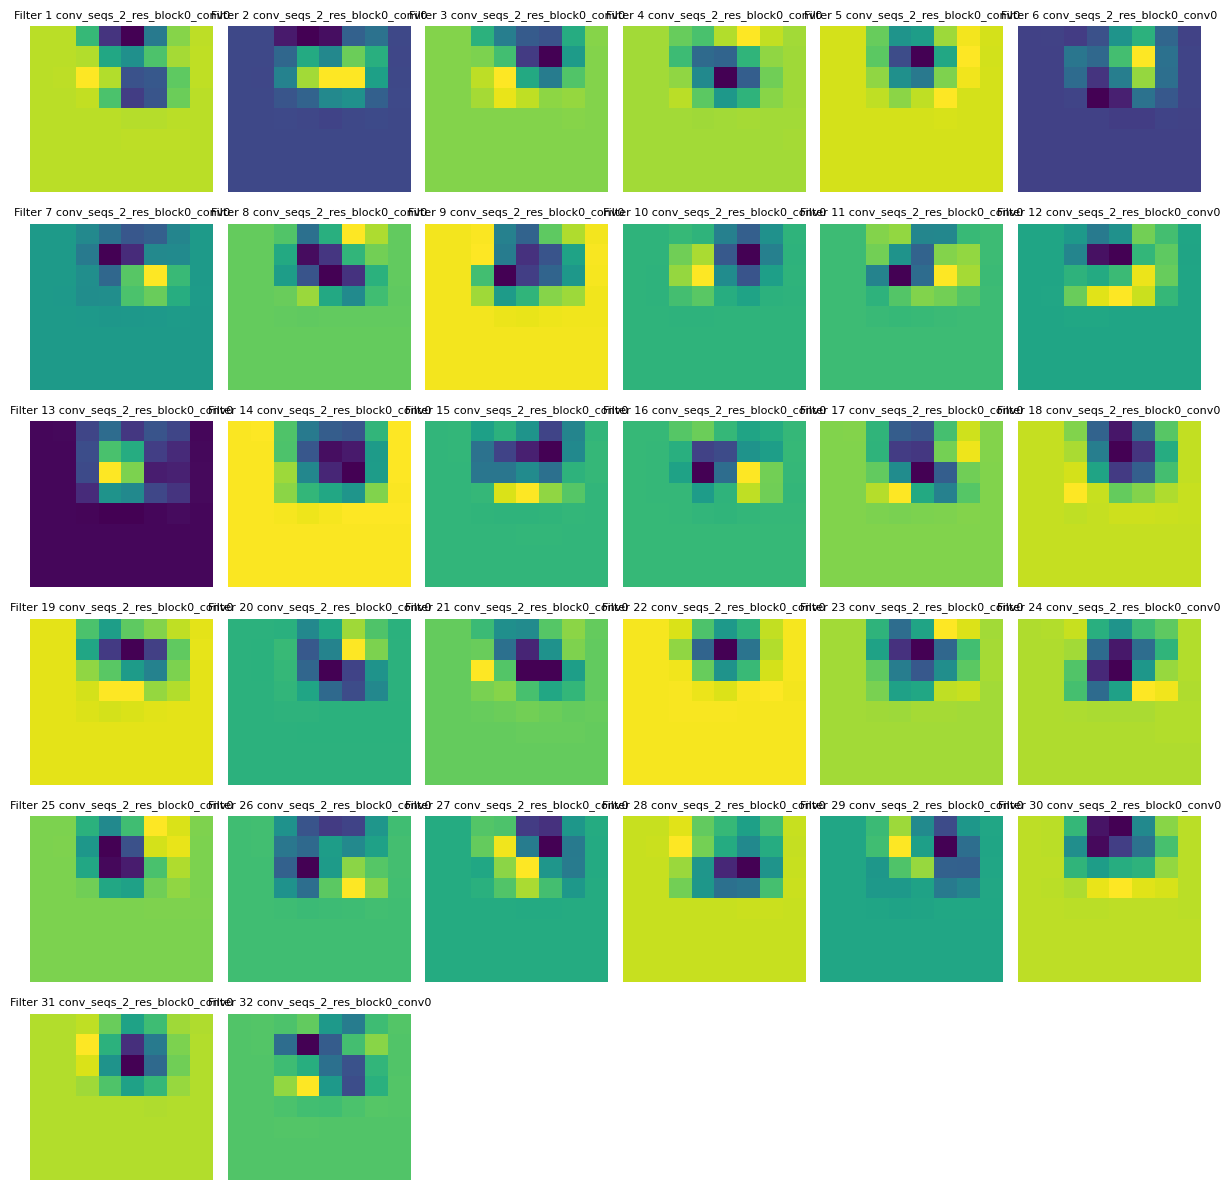

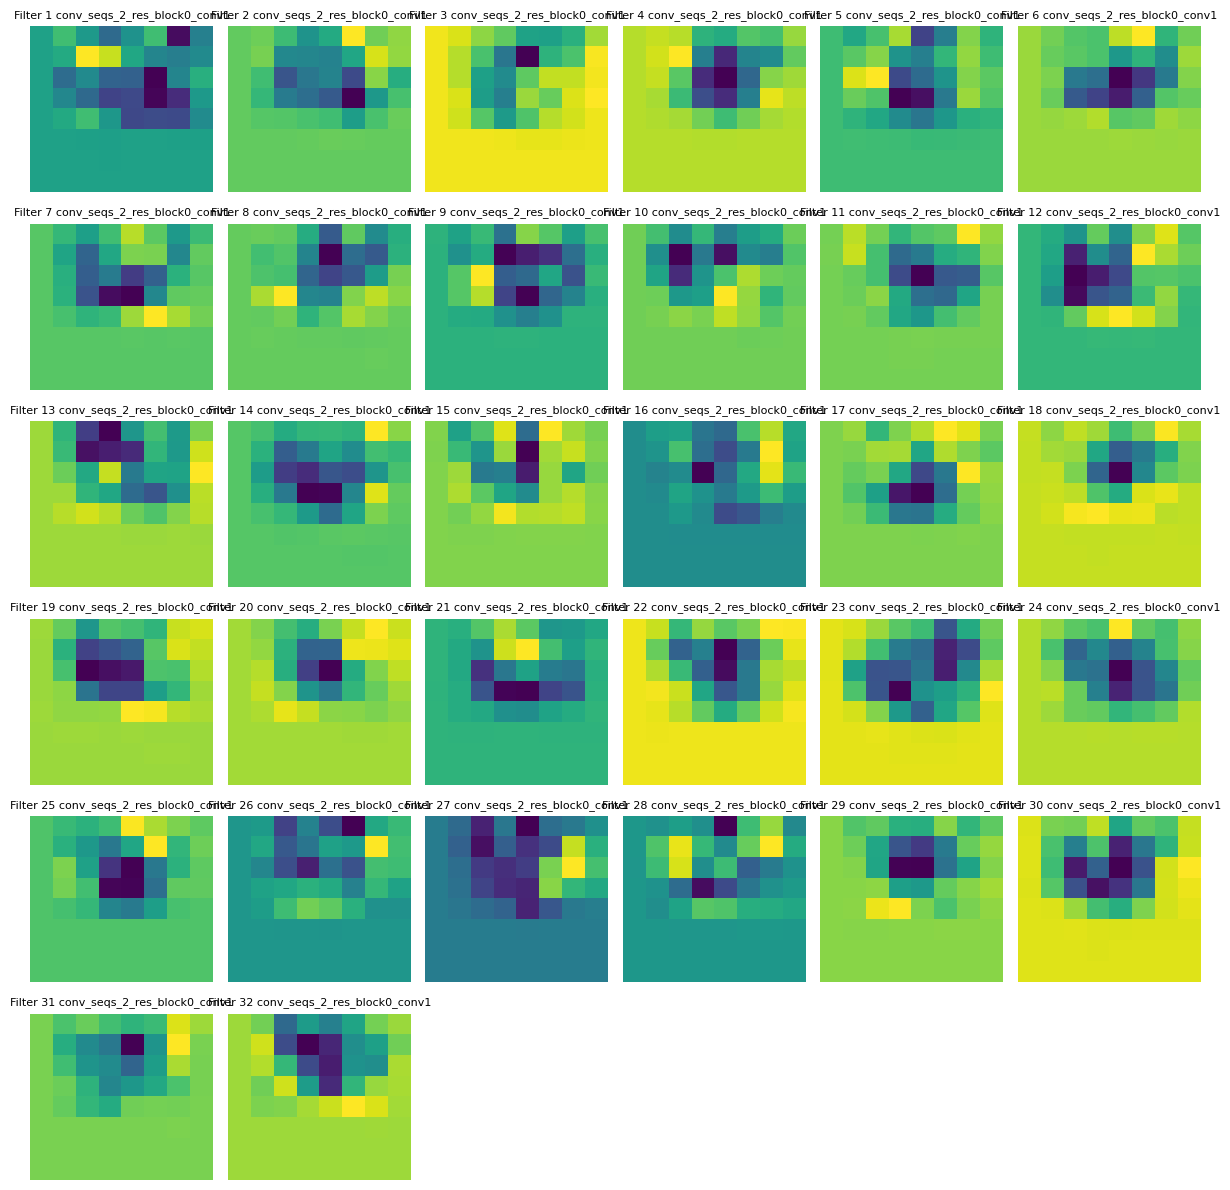

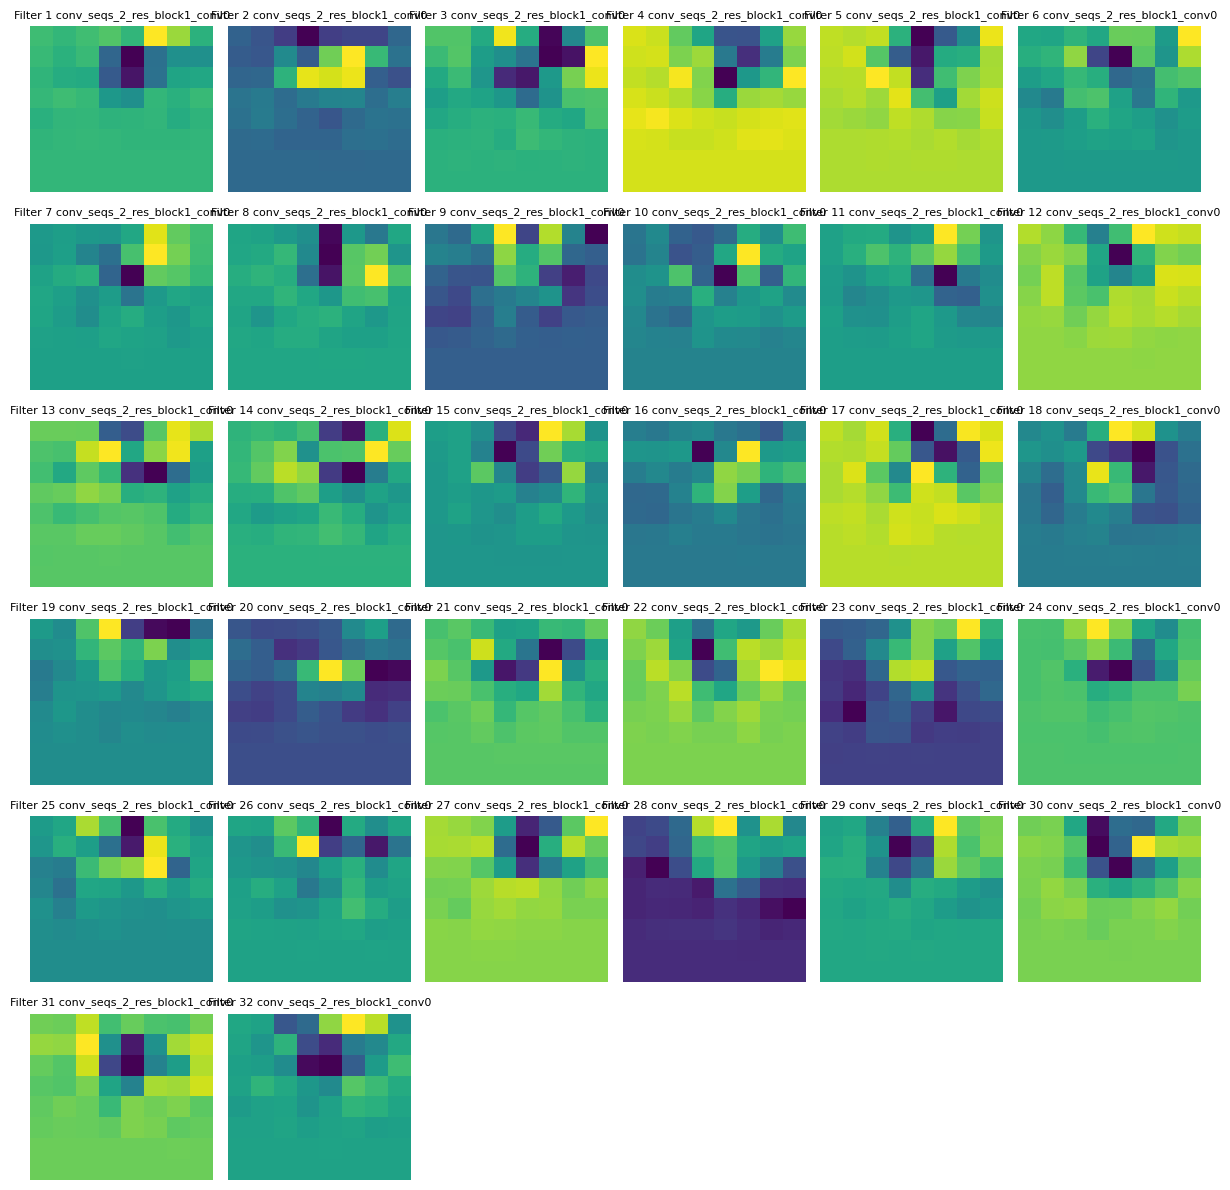

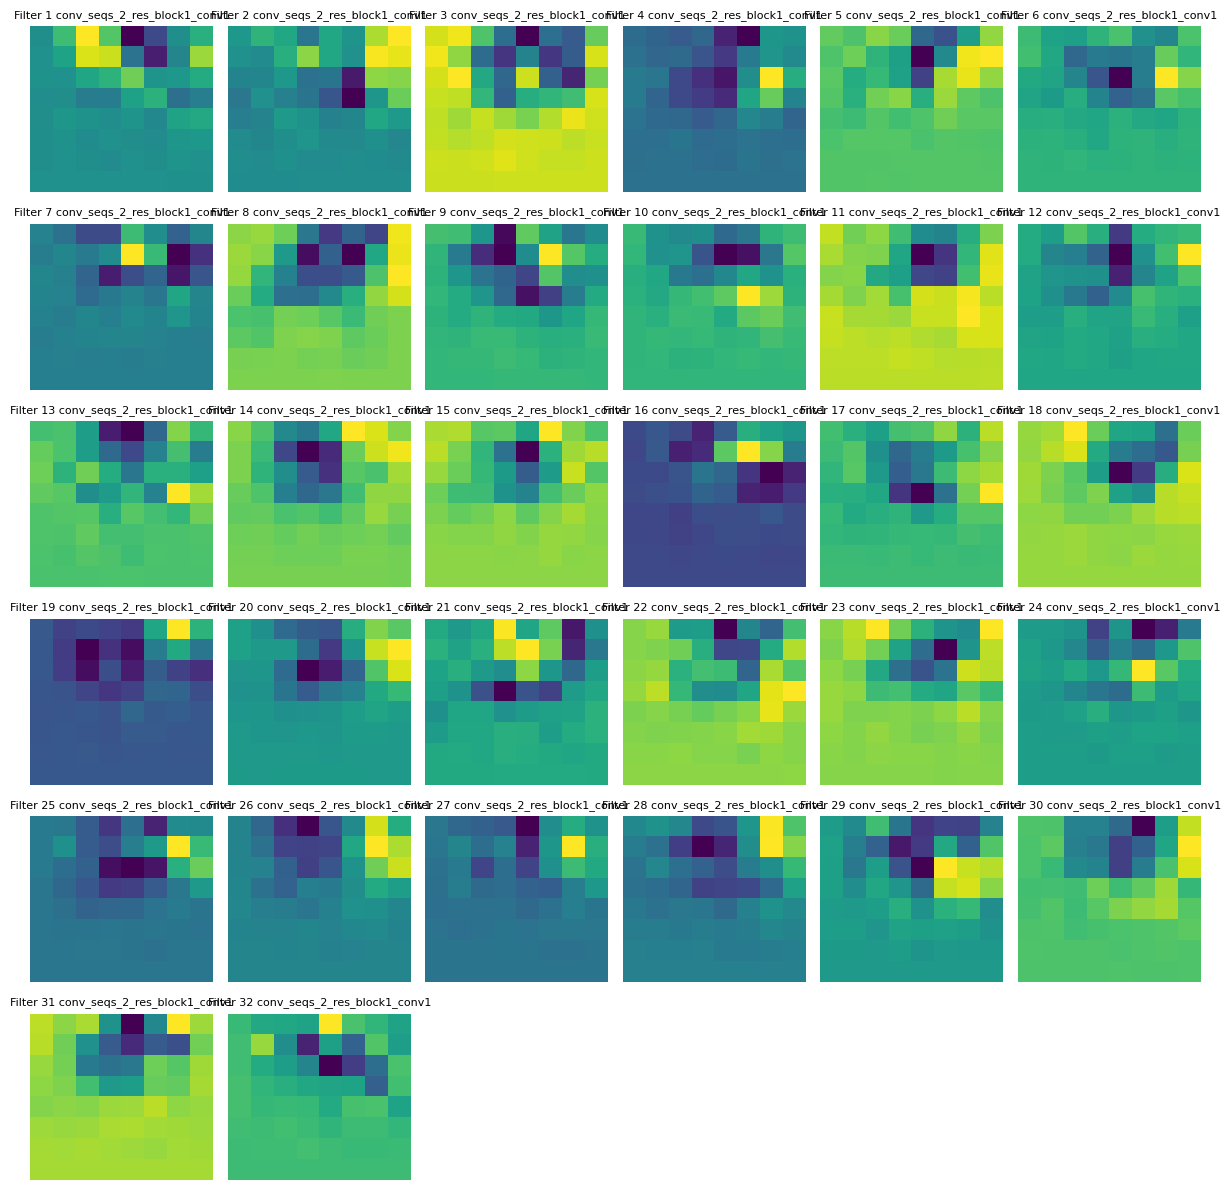

In [120]:
plot_activations_for_layers(difference_patched_activations, difference_patched_activations.keys())

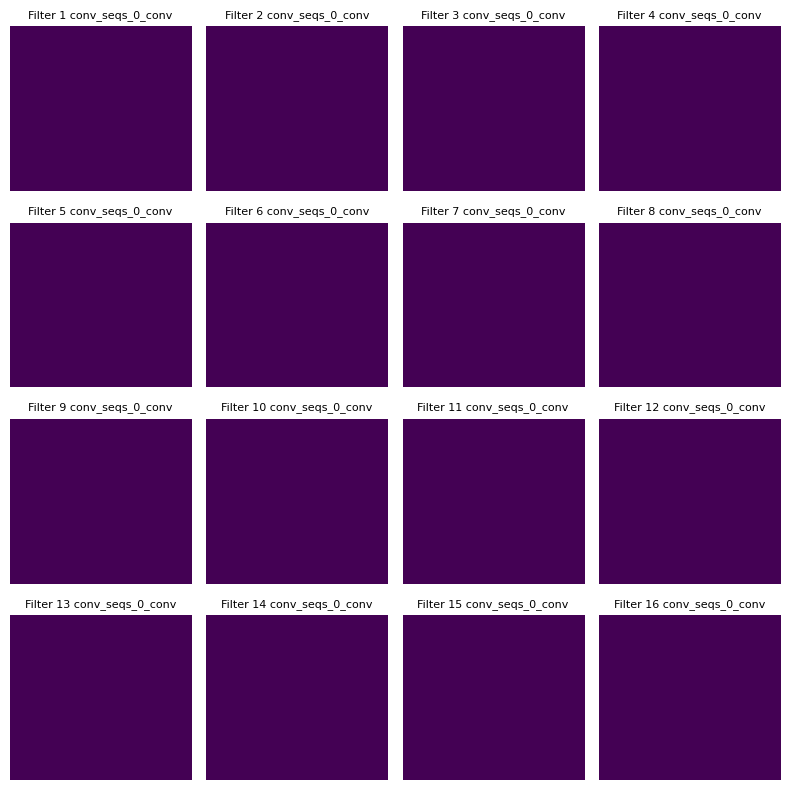

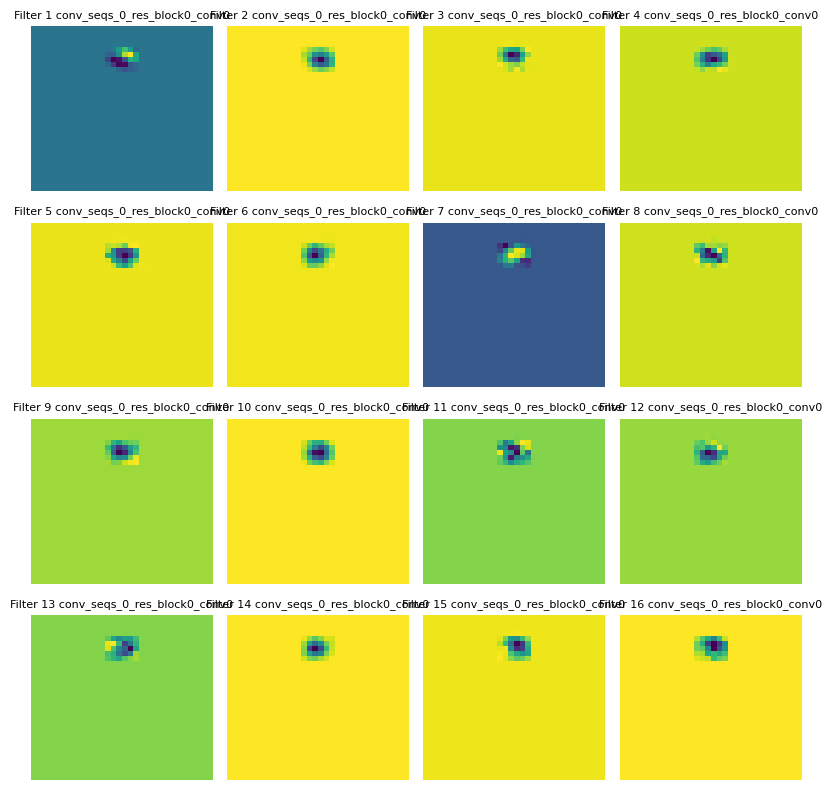

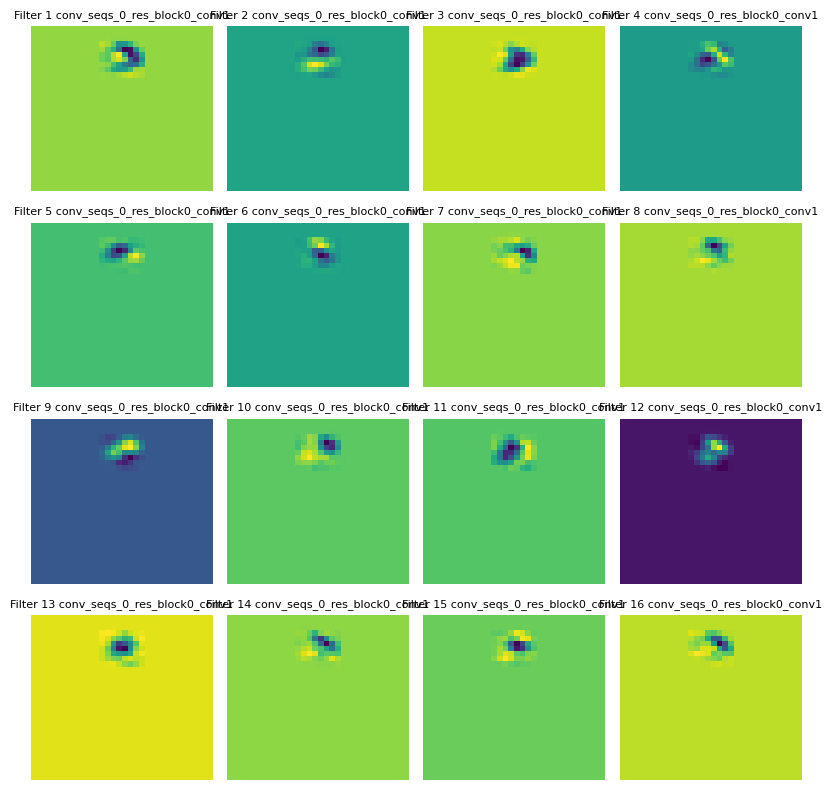

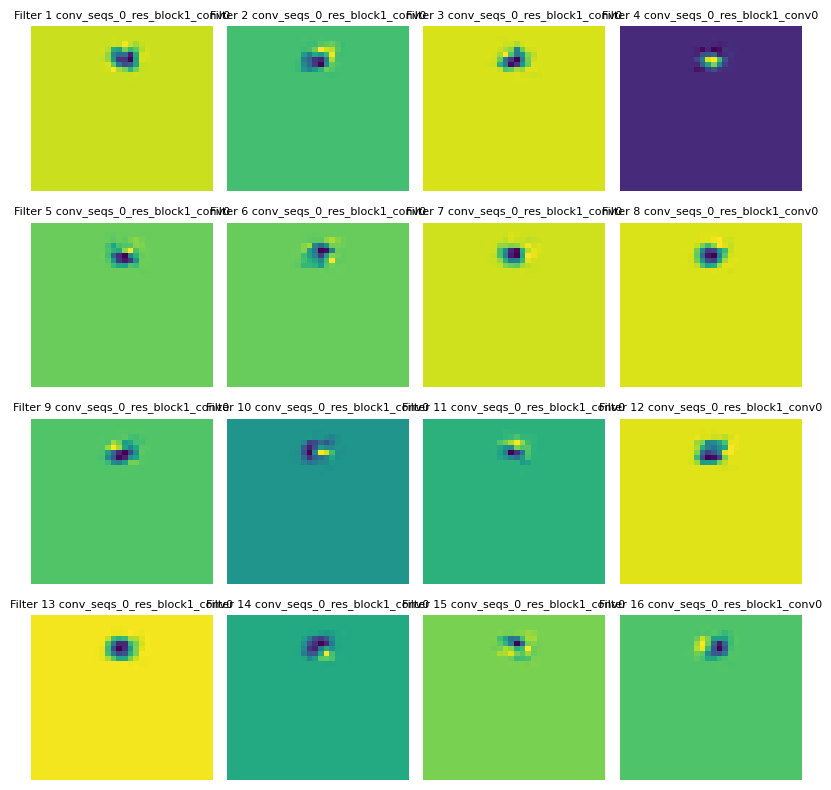

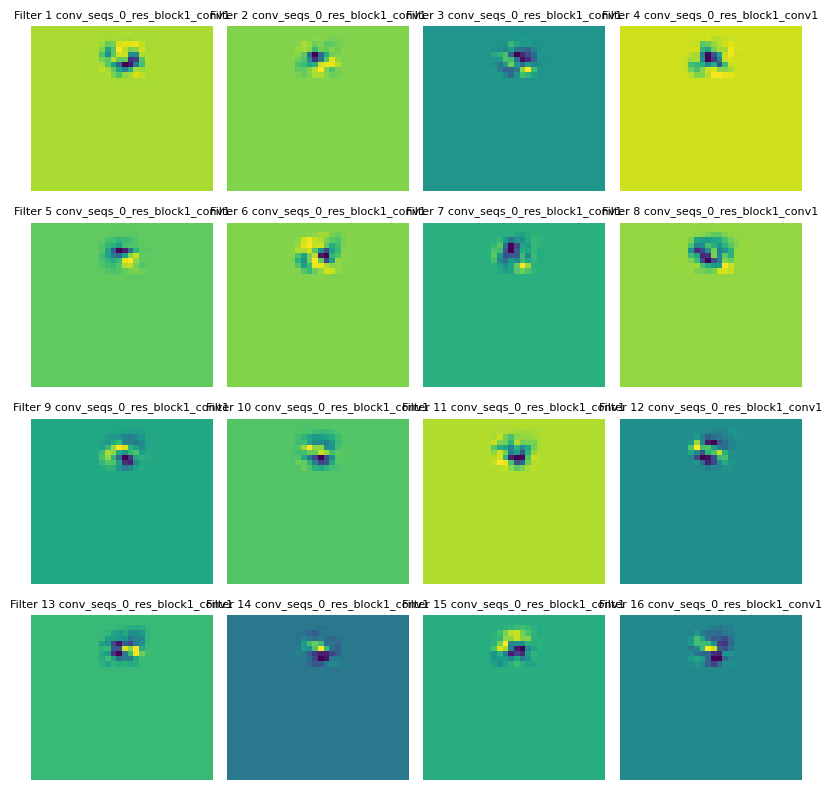

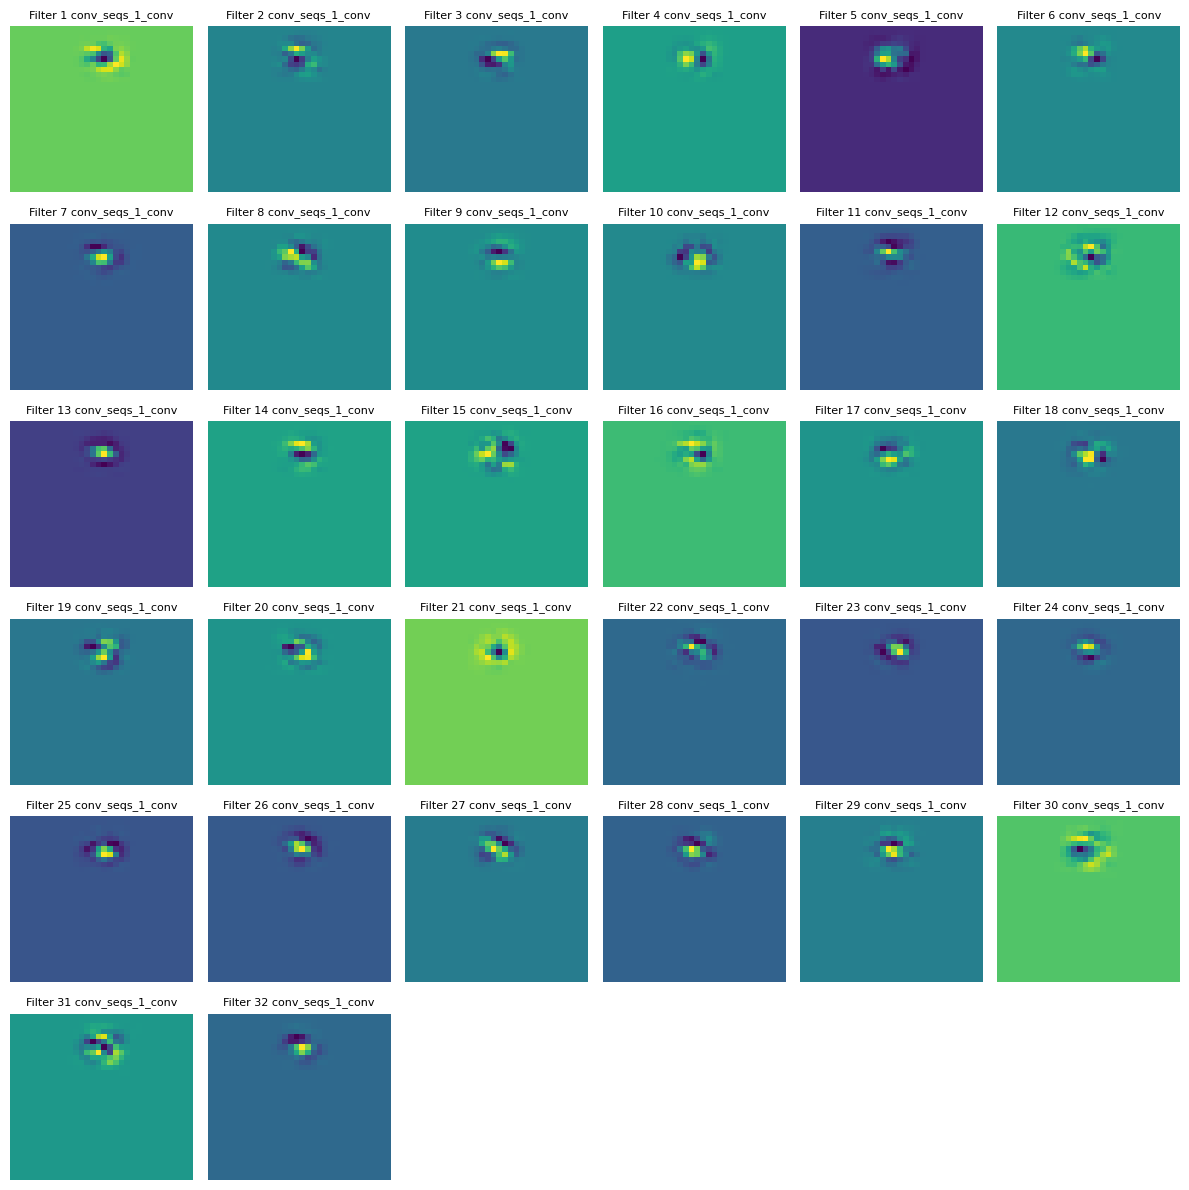

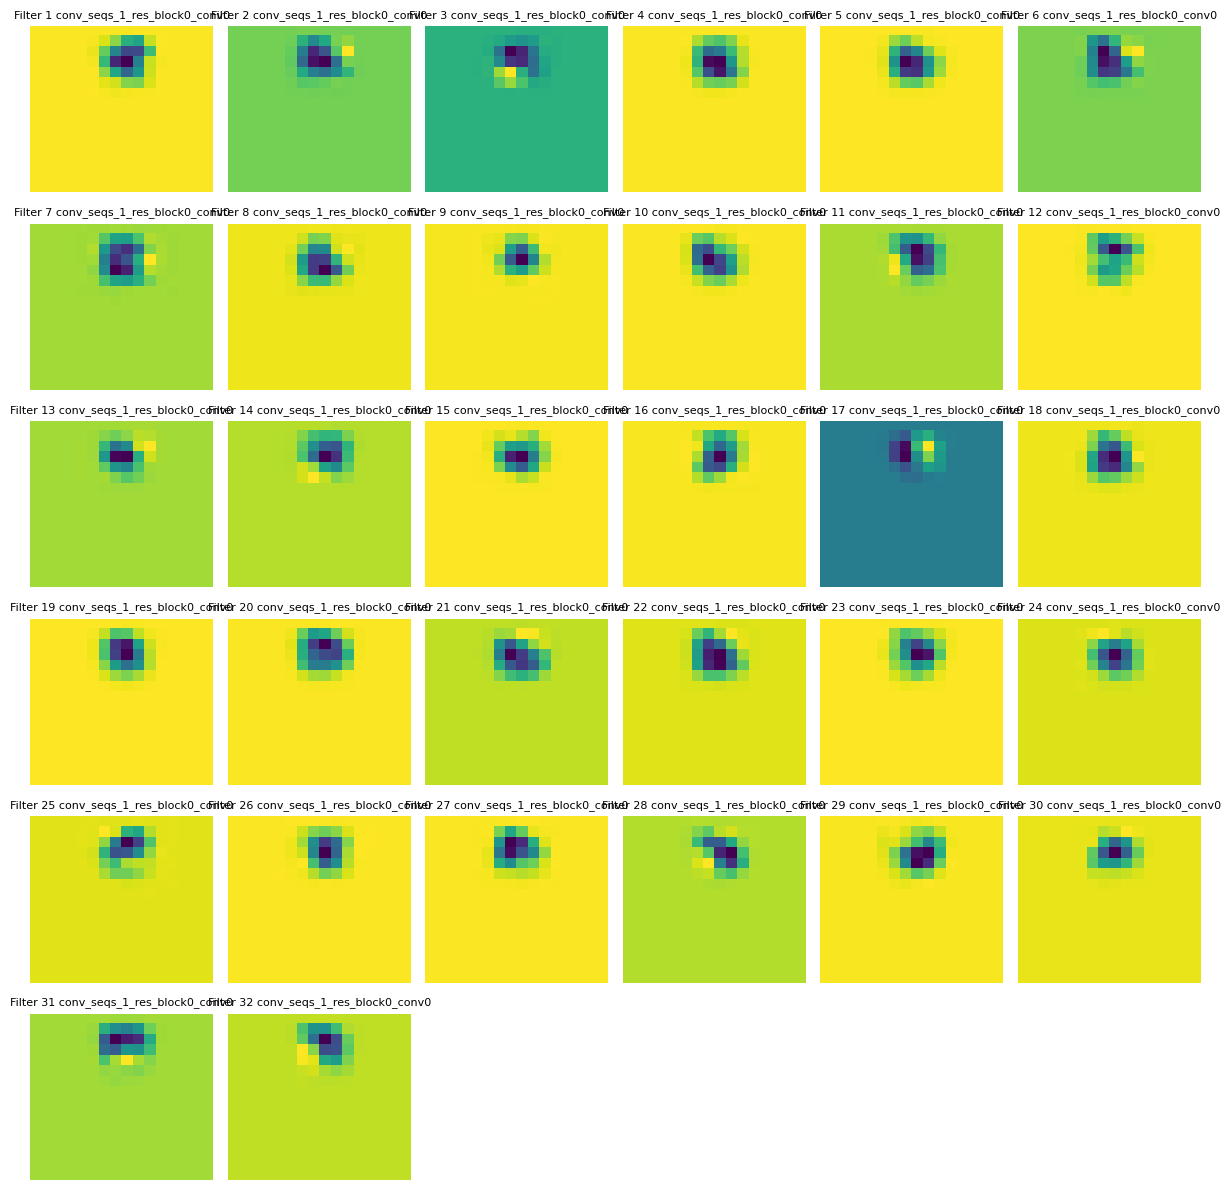

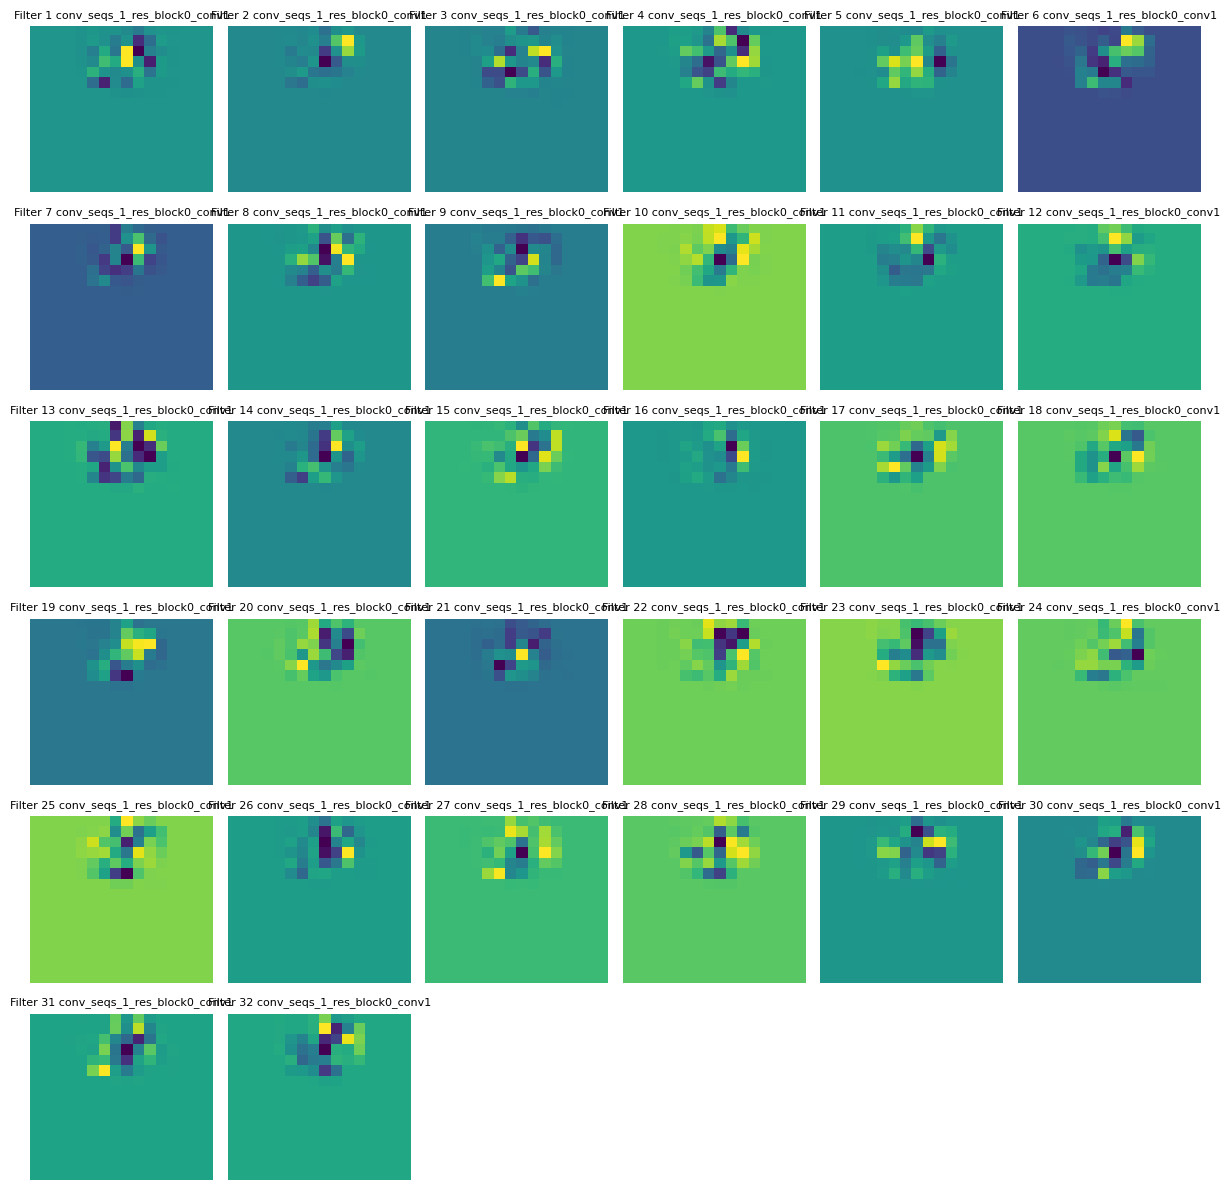

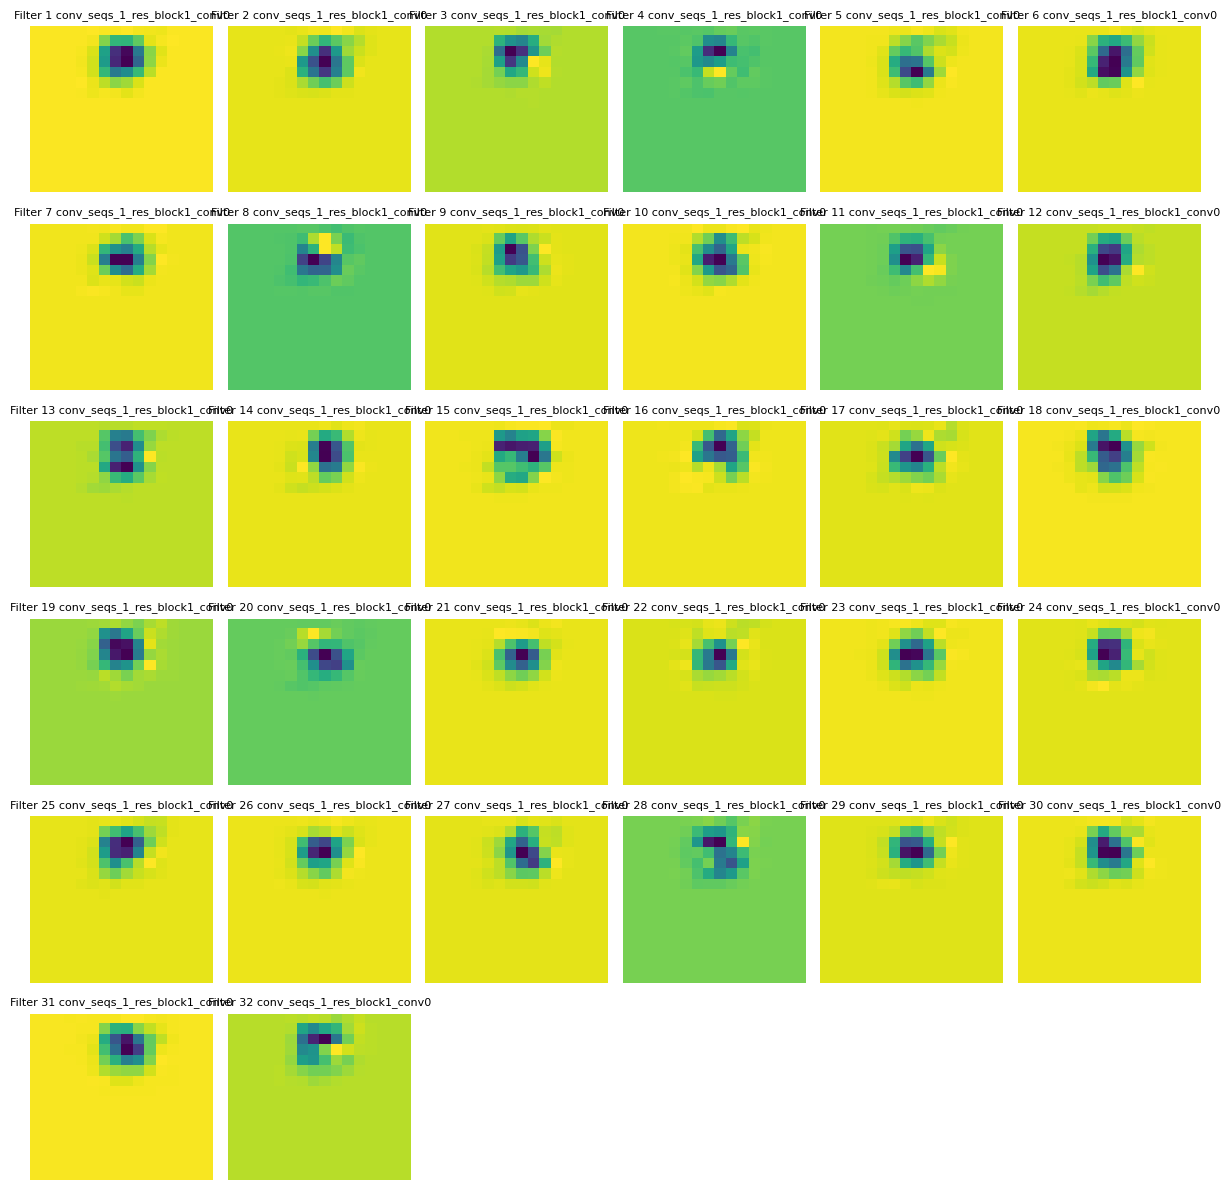

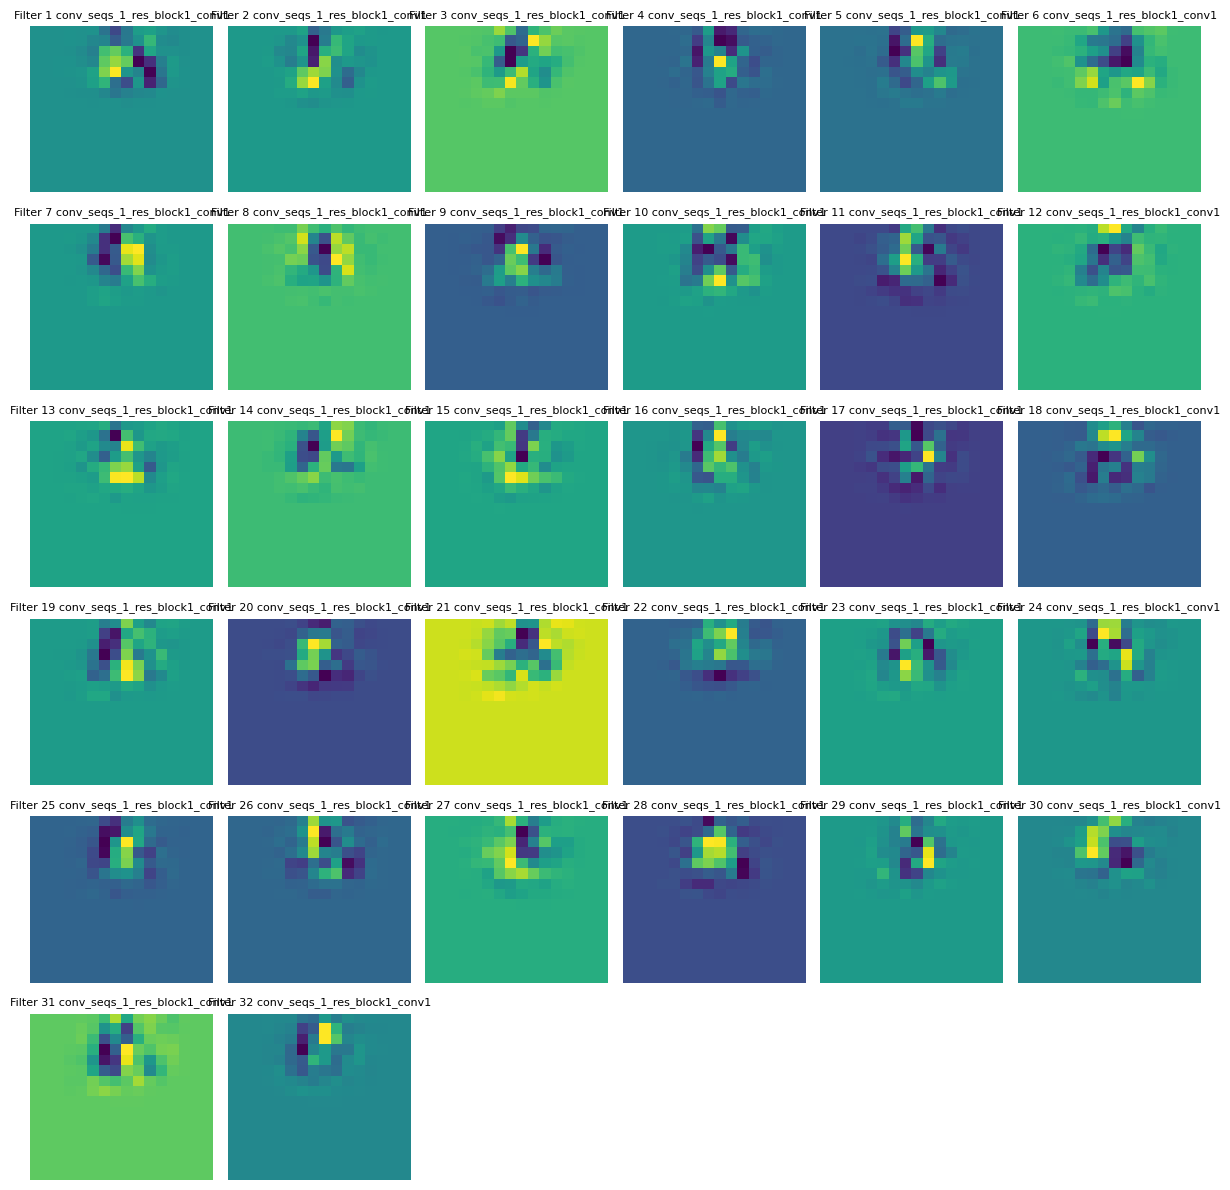

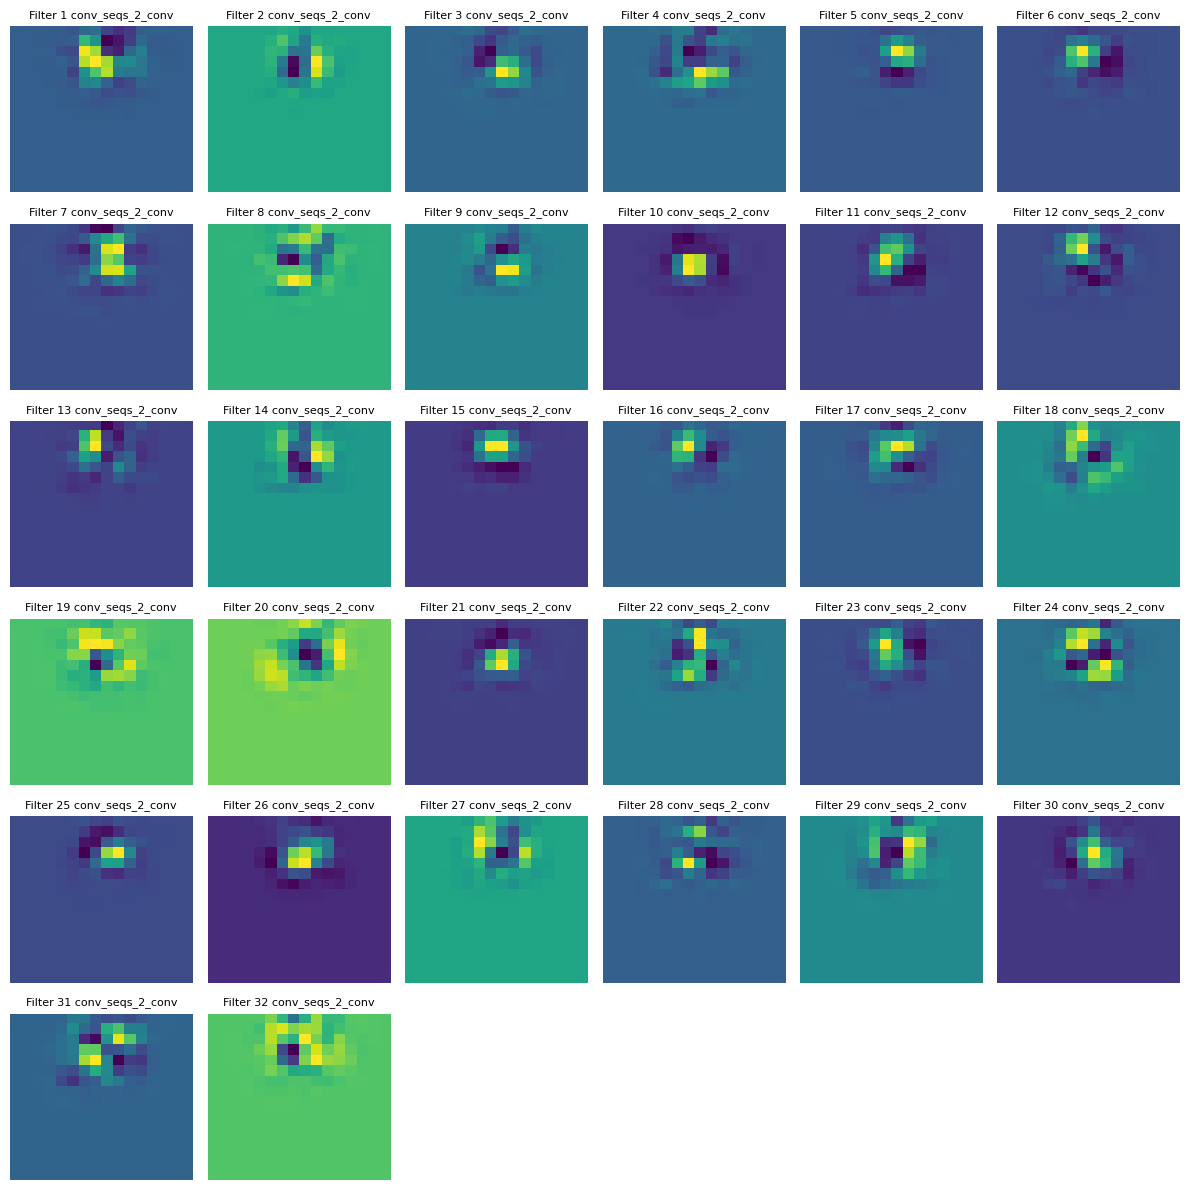

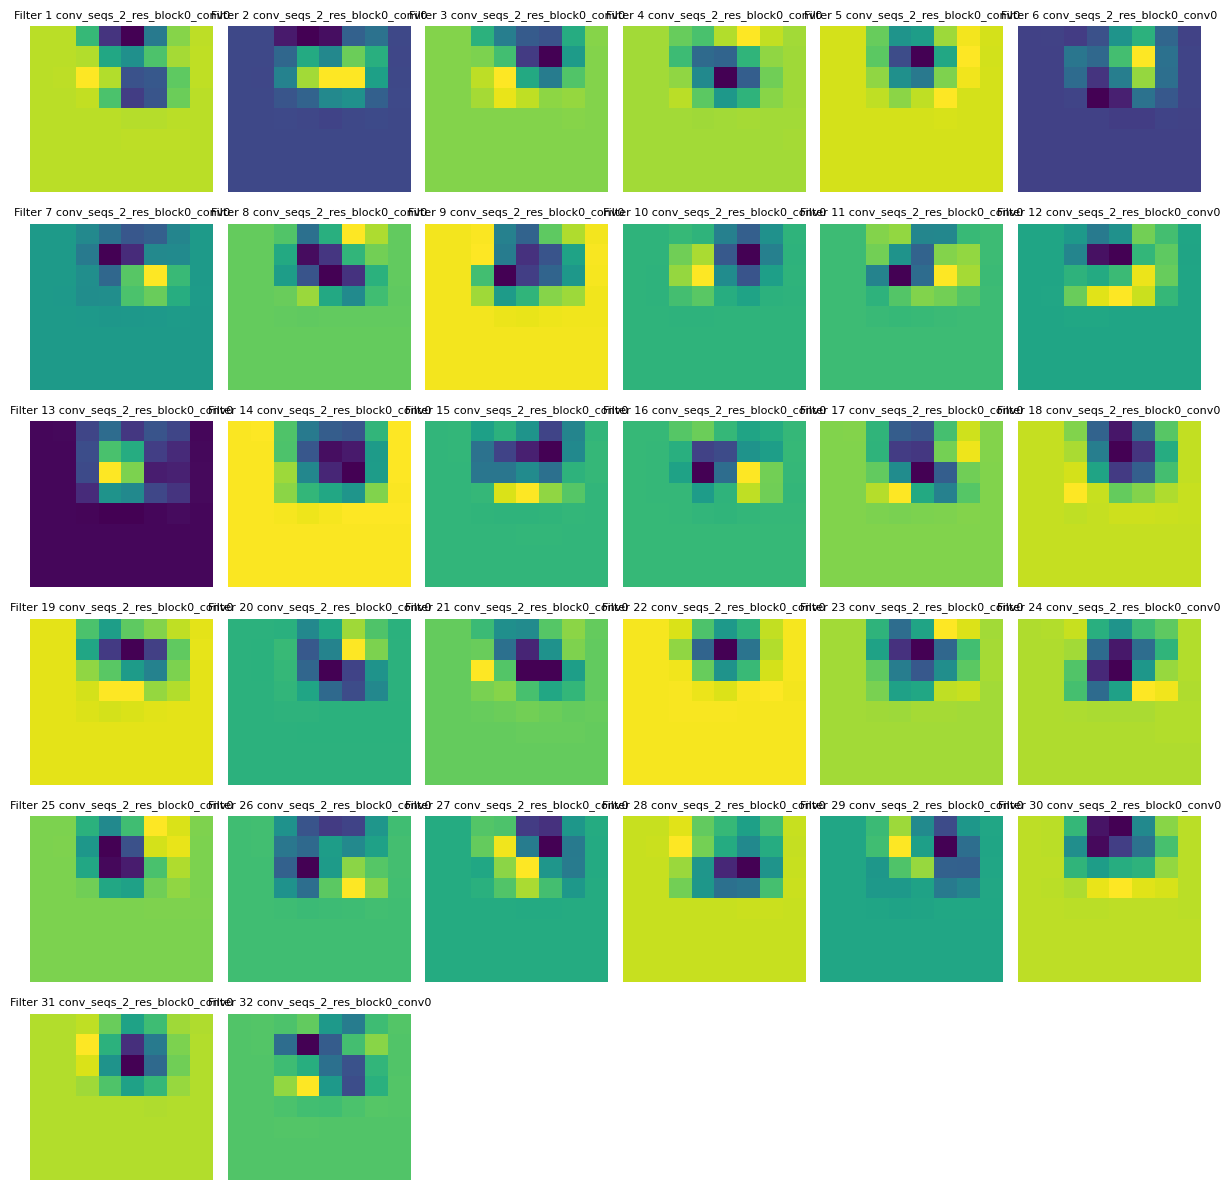

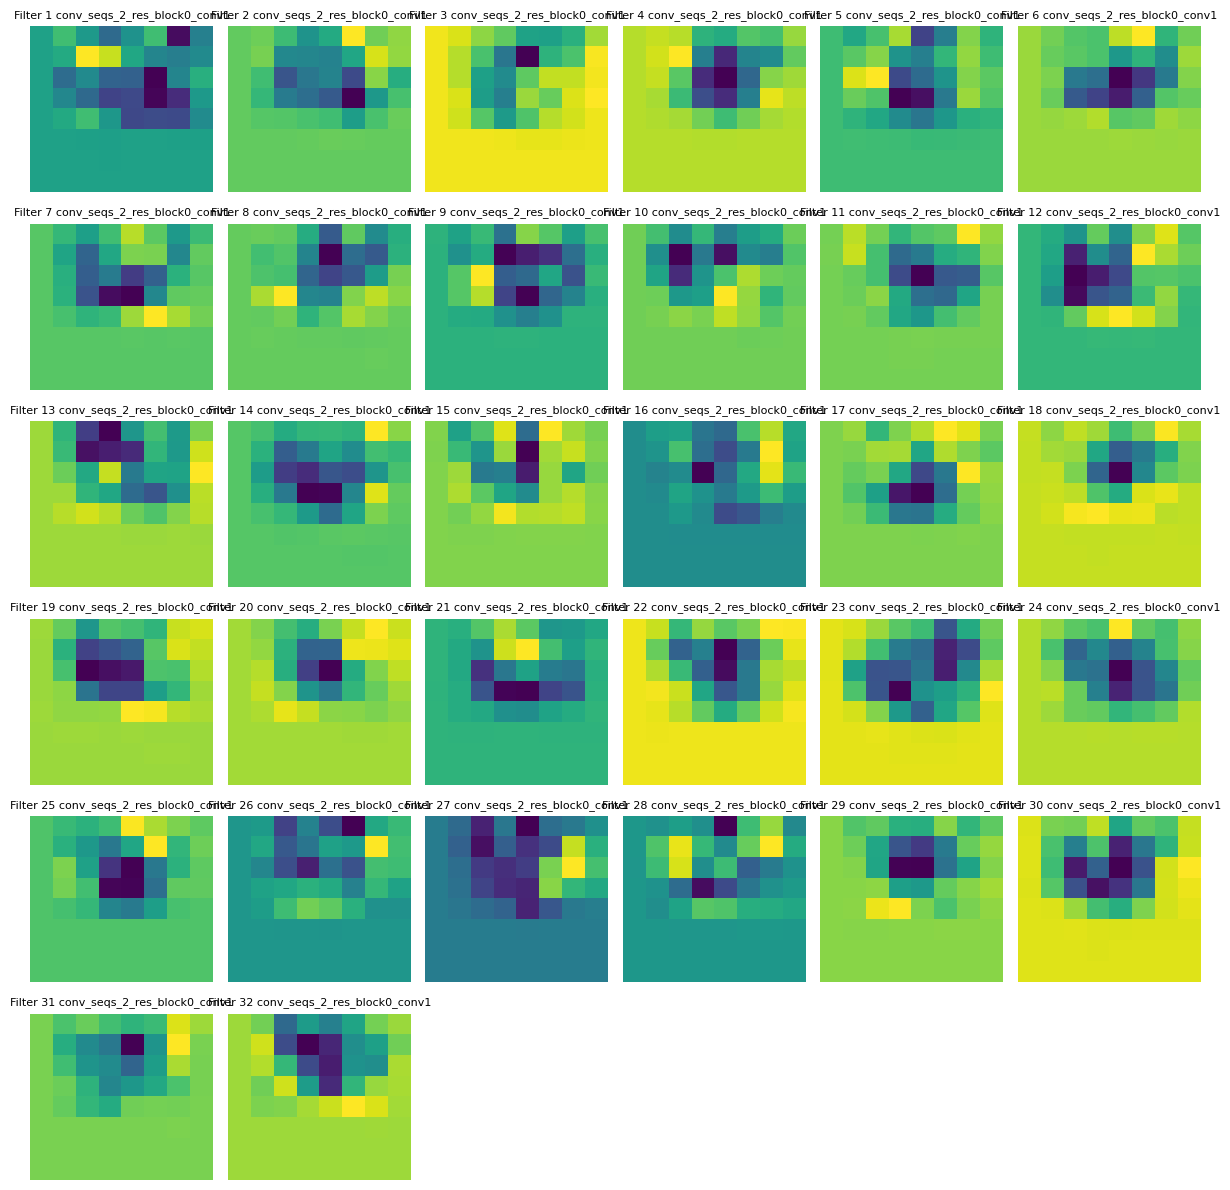

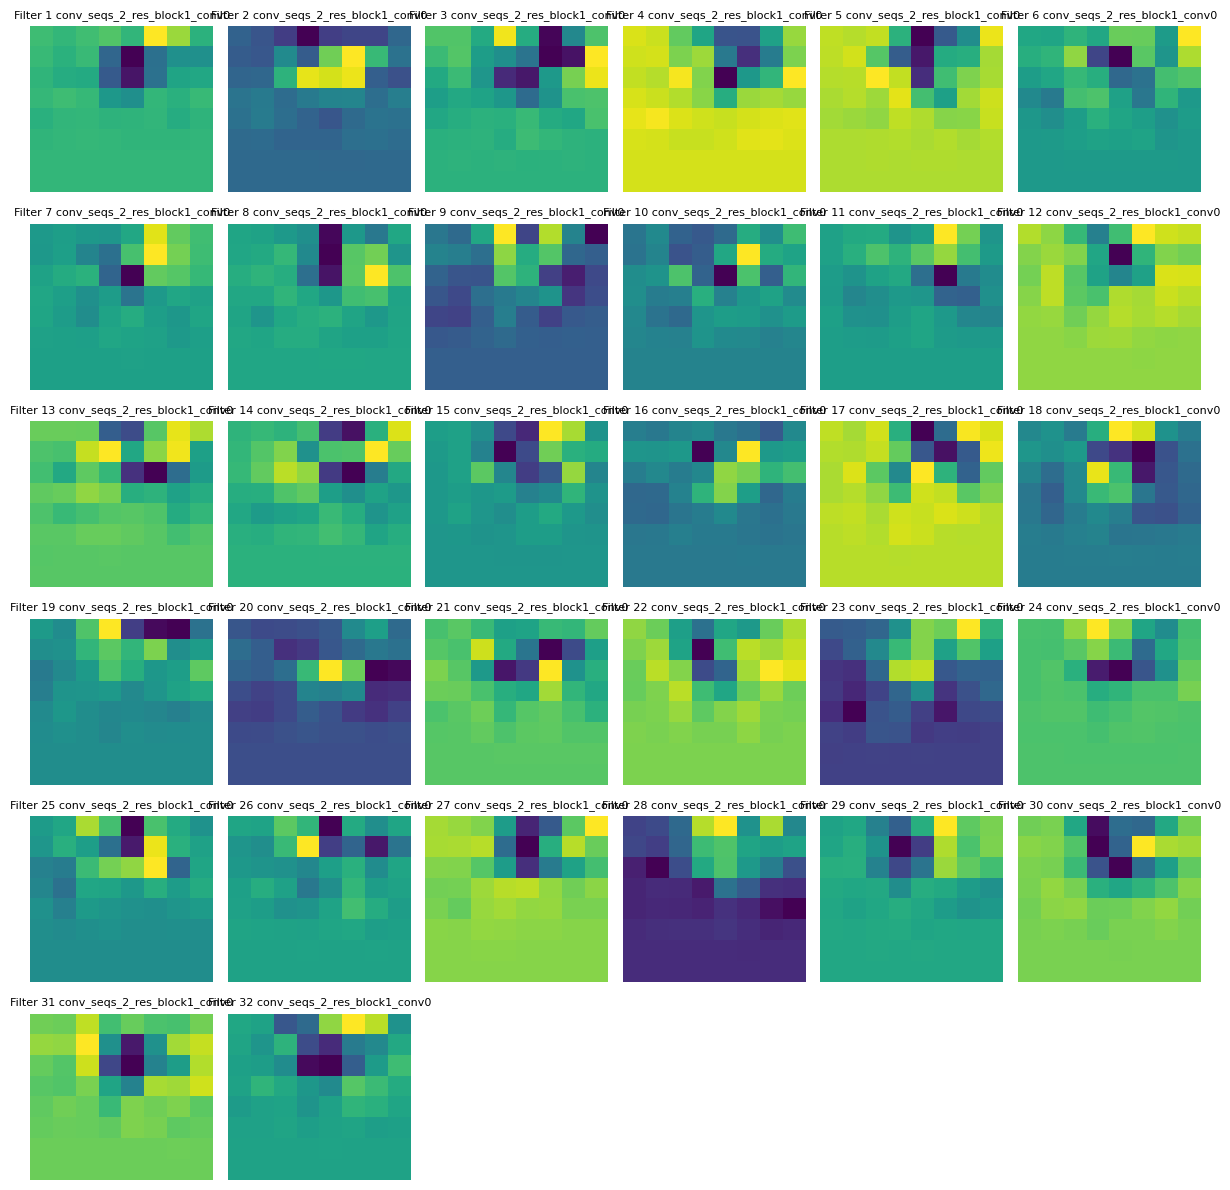

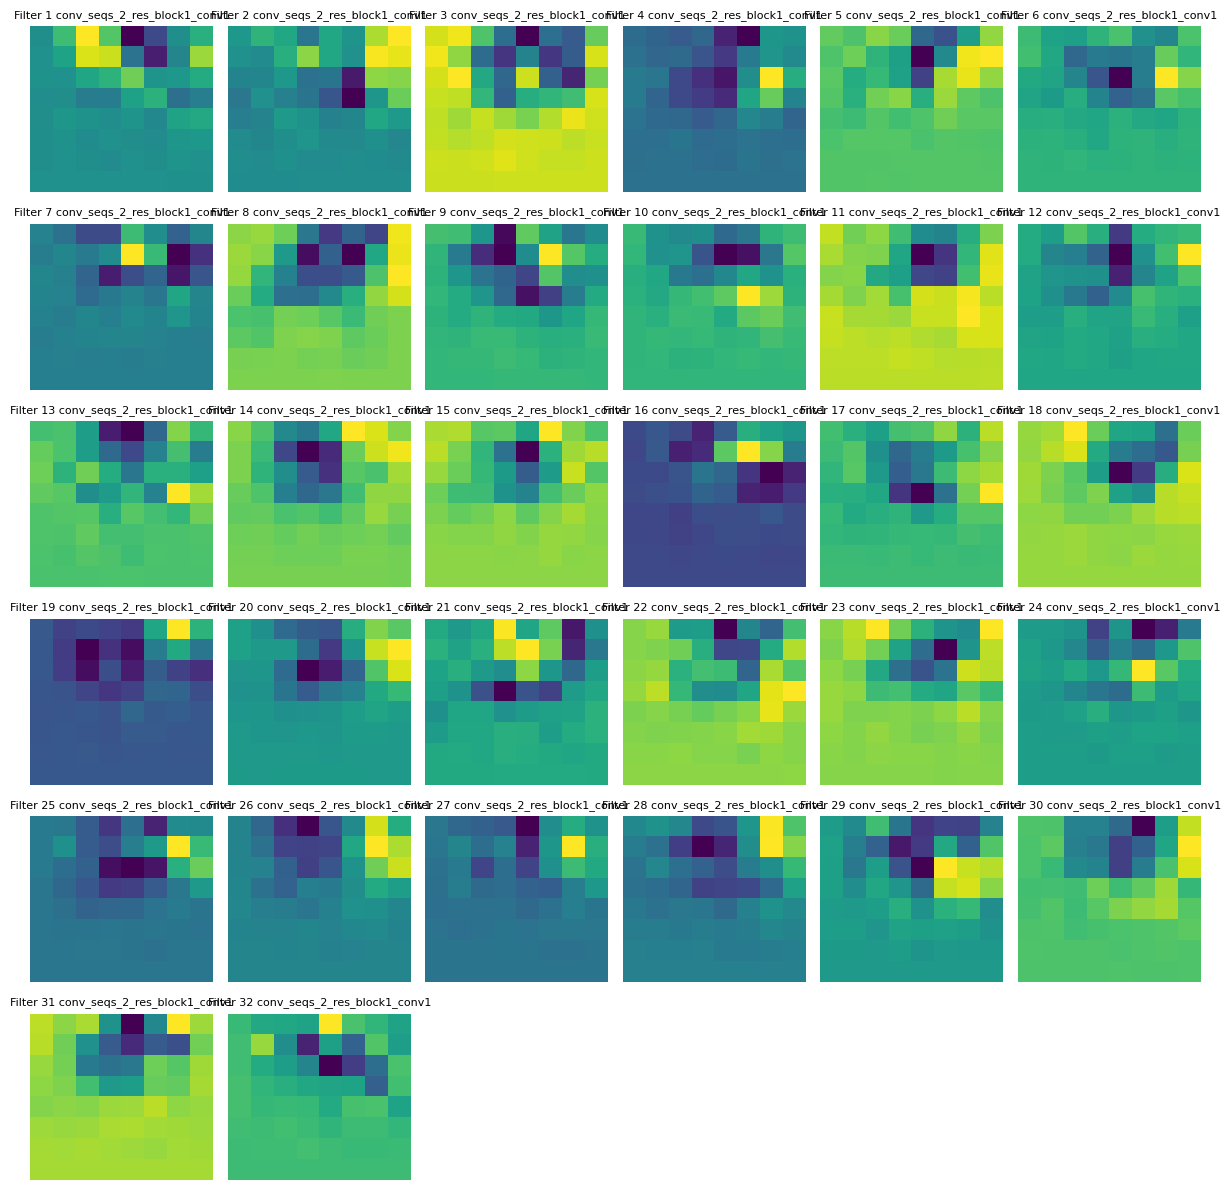

In [37]:
plot_activations_for_layers(difference_patched_activations, difference_patched_activations.keys())

Revised Algorithm with Custom Ablation Method:
Step 1: Preparation
Input: Neural network model, input data, a list of layer names to be evaluated, epsilon (ε) threshold for logit change.
Output: Set of important channels (with layer names) whose ablation significantly affects the output logits.
Step 2: Baseline Logit Calculation
Pass the input data through the unmodified model to obtain the baseline logits.
Step 3: Layer-wise Channel Ablation
For each layer specified in the list of layer names:
Ablate one channel at a time using the provided method. This is done by setting the to_patch_activation_tensor to 0 for the target channel and applying the custom hook to ablate it.
Calculate the logits with the ablated channel.
Compare these logits to the baseline logits to assess the impact of ablating the channel.
Step 4: Identifying Important Channels
For each channel in each layer, determine if the maximum absolute change in logits exceeds the epsilon (ε) threshold.
If it does, mark this channel as "important.

In [127]:
import torch
import copy

def replace_dots(input_string):
    return input_string.replace('.', '_')

def evaluate_channel_importance_with_fixed_channels(model, input_data, layer_paths, epsilon, num_channels=16):
    """
    Evaluates the importance of channels in specified layers, given a fixed number of channels.
    
    Parameters:
    - model: The neural network model.
    - input_data: Input data for the model.
    - layer_names: List of layer names to evaluate.
    - epsilon: Threshold for change in logits to consider a channel important.
    - num_channels: Number of channels in each layer (default is 16).
    
    Returns:
    List of tuples (layer_name, channel_index) of important channels.
    """
    model.eval()
    important_channels = []

    # Baseline logits without any ablation
    with torch.no_grad():
        baseline_logits,cache = model_activations.run_with_cache(input_data,layer_paths)

        logits = baseline_logits[0].logits  # discard the output of the critic in our actor critic network
    
        probabilities = torch.softmax(logits, dim=-1)
    
        action = torch.multinomial(probabilities, 1).item() 
        print(action)
    
    model_activations.clear_hooks()


    # Iterate over specified layers
    for layer_name in layer_paths:
        # Ablate each channel one at a time
        print("ablating" , layer_name)
        for channel in range(num_channels):
            # Make a copy of the model for each channel to ensure isolation
            modified_model = copy.deepcopy(model)
            # Setting up hooks to ablate the current channel

            to_patch_tensor = cache[replace_dots(layer_name)][0]
            to_patch_tensor[channel] = 0

            modified_logits, _ = patch_activations(input_data, layer_paths,to_patch_tensor, to_change_name=layer_name, ablate="False")
            # Determine if the channel is important based on the change in logits
            #print(baseline_logits[1].item())
            max_change = abs(baseline_logits[1].item() - modified_logits[1].item())
            #print(max_change)
            if max_change > epsilon:
                important_channels.append((layer_name, channel))

    return important_channels

# Example usage
input_data = tensor_gem
epsilon = 2
important_channels = evaluate_channel_importance_with_fixed_channels(model, input_data, layer_paths1, epsilon)
print("Important Channels:", important_channels)




9
ablating conv_seqs.0.conv
ablating conv_seqs.0.res_block0.conv0
ablating conv_seqs.0.res_block0.conv1
ablating conv_seqs.0.res_block1.conv0
ablating conv_seqs.0.res_block1.conv1
ablating conv_seqs.1.conv
ablating conv_seqs.1.res_block0.conv0
ablating conv_seqs.1.res_block0.conv1
ablating conv_seqs.1.res_block1.conv0
ablating conv_seqs.1.res_block1.conv1
ablating conv_seqs.2.conv
ablating conv_seqs.2.res_block0.conv0
ablating conv_seqs.2.res_block0.conv1
ablating conv_seqs.2.res_block1.conv0
ablating conv_seqs.2.res_block1.conv1
Important Channels: []
